<a href="https://colab.research.google.com/github/alouwyck/PhD/blob/main/chapter2_generalized_semi_analytical_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

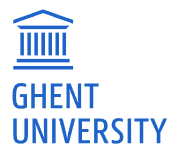<br>

**Axisymmetric Flow in Multilayer Aquifer Systems:**<br>
**Solutions and Theoretical Considerations**<br><br>
Andy Louwyck (2023)

---



---

# **CHAPTER 2: Semi-Analytical Solution Method for Simulating Multilayer Flow**

This Jupyter notebook implements the generalized semi-analytical solution method for simulating axisymmetric and parallel multilayer flow developed in chapter 2 of my PhD thesis (Louwyck, 2023). It also implements several well-known solutions presented in the hydrogeological literature and discussed in section 2.5 of chapter 2.

## Solutions

Import the required packages, modules, and functions.

In [1]:
from abc import ABC, abstractmethod
import numpy as np
import scipy
from scipy.linalg import eig, inv
from scipy.special import exp1, erfc, erf, i0, k0, k1, i1
from scipy.linalg import LinAlgWarning
from math import factorial, log
import warnings
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

Check versions:

In [2]:
# print("NumPy", np.__version__)
# print("Matplotlib", matplotlib.__version__)
# print("SciPy", scipy.__version__)

### Generalized multilayer solution

Class to simulate steady two-dimensional radial or parallel flow in a multilayer aquifer system:

In [3]:
class Steady:
    """
    Class to simulate steady two-dimensional radial or parallel flow in a multilayer aquifer system.

    Parameters
    ----------
    T : array_like
      Layer transmissivities [L²/T]. The length of `T` is equal to the number of layers.
    Q : array_like, default: `None`
      Discharges [L³/T] at inner model boundary. The length of `Q` is equal to the number of layers.
    h_in : array_like, default: `None`
         Constant heads [L] at inner model boundary. The length of `h_in` is equal to the number of layers.
    c : array_like
      Vertical resistances [T] between layers. The length of `c` is the number of layers minus one.
    c_top : float, default: `inf`
          Vertical resistance [T] of the upper boundary of the aquifer system.
          By default, the upper boundary is impervious.
    h_top : float, default: `0.0`
          Constant head [L] of the upper boundary condition.
    c_bot : float, default: `inf`
          Vertical resistance [T] of the lower boundary of the aquifer system.
          By default, the lower boundary is impervious.
    h_bot : float, default: `0.0`
          Constant head [L] of the lower boundary condition.
    r_in : float, default: `0.0`
         Radial or horizontal distance [L] of the inner model boundary.
    r_out : float, default: `inf`
          Radial or horizontal distance [L] of the outer model boundary.
    h_out : array_like, default: `None`
          Constant head [L] at the outer model boundary for each layer.
          The length of `h_out` is equal to the number of layers.
          By default, the constant heads at the outer boundary are zero.
    N : array_like, default: `None`
      Recharge flux [L/T] for each layer.
      The length of `N` is equal to the number of layers.
      By default, the recharge in each layer is zero.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Attributes
    ----------
    nl : int
       Number of layers
    no_warnings : bool, default: True
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.

    Methods
    -------
    h(r) :
         Calculate hydraulic head h [L] at given distances r [L].
    qh(r) :
          Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L].
    """
    def __init__(self, T, Q=None, h_in=None, c=None, c_top=np.inf, h_top=0.0, c_bot=np.inf,
                 h_bot=0.0, r_in=0.0, r_out=np.inf, h_out=None, N=None, axi=True):
        self.T = self._to_array(T)  # (nl, )
        self.nl = len(self.T)  # int
        self.Q = None if Q is None else self._to_array(Q)  # (nl, )
        self.h_in = None if h_in is None else self._to_array(h_in)  # (nl, )
        self.c = np.array([]) if self.nl == 1 else self._to_array(c)  # (nl-1, )
        self.c_top = c_top  # float
        self.h_top = h_top  # float
        self.c_bot = c_bot  # float
        self.h_bot = h_bot  # float
        self.confined = np.all(np.isinf([self.c_top, self.c_bot]))  # bool
        self.r_in = r_in  # float
        self.r_out = r_out  # float
        self.h_out = self._check_array(h_out)  # (nl, )
        self.N = self._check_array(N)  # (nl, )
        self.axi = axi  # bool
        self.no_warnings = True
        self._initialized = False  # becomes True the first time _out_() has been called

    def h(self, r):
        return self._out_('_h_', r)

    def qh(self, r):
        return self._out_('_qh_', r)

    def _ini_(self):
        self._Ab_()
        self._eig_()
        self._bc_()

    def _Ab_(self):
        c = np.hstack((self.c_top, self.c, self.c_bot))
        Tc0 = 1 / (self.T * c[:-1])  # (nl, )
        Tc1 = 1 / (self.T * c[1:])  # (nl, )
        self._idx = np.diag_indices(self.nl)
        irow, icol = self._idx
        self._A = np.zeros((self.nl, self.nl))  # (nl, nl)
        self._A[irow, icol] = Tc0 + Tc1
        self._A[irow[:-1], icol[:-1] + 1] = -Tc1[:-1]
        self._A[irow[:-1] + 1, icol[:-1]] = -Tc0[1:]
        self._b = self.N / self.T  # (nl, )
        self._b[0] += Tc0[0] * self.h_top
        self._b[-1] += Tc1[-1] * self.h_bot

    def _eig_(self):
        self._d, self._V = eig(self._A)  # (nl, ), (nl, nl)
        self._d = np.real(self._d)
        self._inz = np.arange(self.nl)
        if self.confined:
            self._iz = np.argmin(np.abs(self._d))
            self._inz = np.setdiff1d(self._inz, self._iz)
        if len(self._inz) > 0:
            self._sd = np.sqrt(self._d[self._inz])
        self._iV = inv(self._V)
        self._v = np.dot(self._iV, self._b)

    def _bc_(self):
        self._w = np.dot(self._iV, self.h_out)  # (nl, )
        self._alpha = np.zeros(self.nl)  # (nl, )
        self._beta = np.zeros(self.nl)  # (nl, )
        if self.axi:
            self._bessel_()
            if self.Q is not None:
                self._bc_axi_Q_()
            else:
                self._bc_axi_H_()
        else:
            if self.Q is not None:
                self._bc_par_Q_()
            else:
                self._bc_par_H_()

    def _bc_axi_Q_(self):
        self._q = np.dot(self._iV, self.Q / self.T / 2 / np.pi)  # (nl, )
        if self.confined:
            self._alpha[self._iz] = -self._q[self._iz] + self._v[self._iz] * self.r_in ** 2 / 2
            self._beta[self._iz] = self._w[self._iz] + self._v[self._iz] * self.r_out ** 2 / 4 - self._alpha[self._iz] * np.log(self.r_out)
        if len(self._inz) > 0:
            nominator = self._i1_in * self._k0_out + self._k1_in * self._i0_out
            wvd = self._w[self._inz] - self._v[self._inz] / self._d[self._inz]
            self._alpha[self._inz] = (wvd * self._k1_in - self._q[self._inz] * self._k0_out) / nominator
            self._beta[self._inz] = (wvd * self._i1_in + self._q[self._inz] * self._i0_out) / nominator
            i = np.isnan(self._beta[self._inz])
            if np.any(i):
                j = self._inz[i]
                self._beta[j] = self._q[j] / self._k1_in[i]  # if r_out -> inf

    def _bc_axi_H_(self):
        self._u = np.dot(self._iV, self.h_in)  # (nl, )
        if self.confined:
            r_in2, r_out2 = self.r_in ** 2, self.r_out ** 2
            ln_r_in, ln_r_out = np.log(self.r_in), np.log(self.r_out)
            u, w = self._u[self._iz], self._w[self._iz]
            v4 = self._v[self._iz] / 4
            nominator = ln_r_in - ln_r_out
            self._alpha[self._iz] = (u - w + v4 * (r_in2 - r_out2)) / nominator
            self._beta[self._iz] = (ln_r_in * (v4 * r_out2 + w) - ln_r_out * (v4 * r_in2 + u)) / nominator
        if len(self._inz) > 0:
            vd = self._v[self._inz] / self._d[self._inz]
            wvd, uvd = self._w[self._inz] - vd, self._u[self._inz] - vd
            nominator = self._i0_in * self._k0_out - self._k0_in * self._i0_out
            self._alpha[self._inz] = (uvd * self._k0_out - wvd * self._k0_in) / nominator
            self._beta[self._inz] = (wvd * self._i0_in - uvd * self._i0_out) / nominator
            i = np.isnan(self._beta[self._inz])
            if np.any(i):
                j = self._inz[i]
                self._beta[j] = uvd[j] / self._k0_in[i]  # if r_out -> inf

    def _bc_par_Q_(self):
        self._q = np.dot(self._iV, self.Q / self.T)  # (nl, )
        if self.confined:
            self._alpha[self._iz] = self._v[self._iz] * self.r_in - self._q[self._iz]
            self._beta[self._iz] = self._w[self._iz] + self._v[self._iz] * self.r_out ** 2 / 2 - self._alpha[self._iz] * self.r_out
        if len(self._inz) > 0:
            e_in, e_out = np.exp(self.r_in * self._sd), np.exp(self.r_out * self._sd)
            nominator = self._sd * (e_in / e_out + e_out / e_in)
            wvd = self._w[self._inz] - self._v[self._inz] / self._d[self._inz]
            self._alpha[self._inz] = (wvd * self._sd / e_in - self._q[self._inz] / e_out) / nominator
            self._beta[self._inz] = (wvd * self._sd * e_in + self._q[self._inz] * e_out) / nominator
            i = np.isnan(self._beta[self._inz])
            if np.any(i):
                j = self._inz[i]
                self._beta[j] = self._q[j] * e_in[i] / self._sd[i]  # if r_out -> inf

    def _bc_par_H_(self):
        self._u = np.dot(self._iV, self.h_in)  # (nl, )
        if self.confined:
            r_in2, r_out2 = self.r_in ** 2, self.r_out ** 2
            nominator = self.r_in - self.r_out
            u, w = self._u[self._iz], self._w[self._iz]
            v2 = self._v[self._iz] / 2
            self._alpha[self._iz] = (v2 * (r_in2 - r_out2) + u - w) / nominator
            self._beta[self._iz] = (self.r_in * (v2 * r_out2 + w) - self.r_out * (v2 * r_in2 + u)) / nominator
        if len(self._inz) > 0:
            e_in, e_out = np.exp(self.r_in * self._sd), np.exp(self.r_out * self._sd)
            nominator = e_in / e_out - e_out / e_in
            vd = self._v[self._inz] / self._d[self._inz]
            wvd, uvd = self._w[self._inz] - vd, self._u[self._inz] - vd
            self._alpha[self._inz] = (uvd / e_out - wvd / e_in) / nominator
            self._beta[self._inz] = (wvd * e_in - uvd * e_out) / nominator
            i = np.isnan(self._beta[self._inz])
            if np.any(i):
                j = self._inz[i]
                self._beta[j] = uvd[i] * e_in[i]  # if r_out -> inf

    def _out_(self, method, r):
        r = self._to_array(r)
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            if not self._initialized:
                self._ini_()
                self._initialized = True
            method = getattr(self, method)  # method _h_ or _qh_ (convert string to function)
            nr = len(r)
            out = np.zeros((self.nl, nr))  # (nl, nr)
            for i in range(nr):
                out[:, i] = method(r[i])
            return out

    def _h_(self, r):
        if self.axi:
            g = np.zeros(self.nl)  # (nl, )
            if self.confined:
                g[self._iz] = self._alpha[self._iz] * np.log(r) + self._beta[self._iz] - self._v[self._iz] * r ** 2 / 4
            if len(self._inz) > 0:
                x = self._sd * r
                i0x = i0(x)
                i0x[np.isnan(i0x)] = np.inf  # x -> inf: i0(x) = inf
                alpha_i0x = self._alpha[self._inz] * i0x
                alpha_i0x[np.isnan(alpha_i0x)] = 0.0  # if alpha = 0 and I0 = Inf
                g[self._inz] = alpha_i0x + self._beta[self._inz] * k0(x) + self._v[self._inz] / self._d[self._inz]
            return np.dot(self._V, g)
        else:
            g = np.zeros(self.nl)  # (nl, )
            if self.confined:
                g[self._iz] = self._alpha[self._iz] * r + self._beta[self._iz] - self._v[self._iz] * r ** 2 / 2
            if len(self._inz) > 0:
                ex = np.exp(self._sd * r)
                alpha_ex = self._alpha[self._inz] * ex
                alpha_ex[np.isnan(alpha_ex)] = 0.0  # if alpha = 0 and exp(x) = inf
                g[self._inz] = alpha_ex + self._beta[self._inz] / ex + self._v[self._inz] / self._d[self._inz]
            return np.dot(self._V, g)

    def _qh_(self, r):
        if self.axi:
            dg = np.zeros(self.nl)  # (nl, )
            if self.confined:
                dg[self._iz] = self._alpha[self._iz] - self._v[self._iz] * r ** 2 / 2
            if len(self._inz) > 0:
                x = self._sd * r
                xi1x = x * i1(x)
                xk1x = x * k1(x)
                xk1x[np.isnan(xk1x)] = 1.0  # r -> 0: x_in * k1(x_in) = 1
                alpha_xi1x = self._alpha[self._inz] * xi1x
                alpha_xi1x[np.isnan(alpha_xi1x)] = 0.0  # if alpha = 0 and I1 = Inf
                dg[self._inz] = alpha_xi1x - self._beta[self._inz] * xk1x
            return 2 * np.pi * self.T * np.dot(self._V, -dg)
        else:
            dg = np.zeros(self.nl)  # (nl, )
            if self.confined:
                dg[self._iz] = self._alpha[self._iz] - self._v[self._iz] * r
            if len(self._inz) > 0:
                ex = np.exp(self._sd * r)
                alpha_ex = self._alpha[self._inz] * ex
                alpha_ex[np.isnan(alpha_ex)] = 0.0  # if alpha = 0 and exp(x) = inf
                dg[self._inz] = self._sd * (alpha_ex + self._beta[self._inz] / ex)
            return self.T * np.dot(self._V, -dg)

    @staticmethod
    def _to_array(arr, dtype=float):
        arr = np.array(arr, dtype=dtype)
        if arr.ndim == 0:
            arr = arr[np.newaxis]
        return arr

    def _check_array(self, arr, dtype=float, n=None):
        if arr is None:
            return np.zeros(self.nl if n is None else n, dtype=dtype)
        else:
            return self._to_array(arr, dtype)

    def _bessel_(self):
        if len(self._inz) > 0:
            x_out = self._sd * self.r_out
            self._i0_out = i0(x_out)
            self._i0_out[np.isnan(self._i0_out)] = np.inf  # x_out -> inf: i0(x_out) = inf
            self._k0_out = k0(x_out)
            if self.Q is not None:
                x_in = self._sd * self.r_in
                self._i1_in = x_in * i1(x_in)
                self._k1_in = x_in * k1(x_in)
                self._k1_in[np.isnan(self._k1_in)] = 1.0  # r_in -> 0: x_in * k1(x_in) = 1
            else:
                x_in = self._sd * self.r_in
                self._i0_in = i0(x_in)
                self._k0_in = k0(x_in)

Class to simulate transient two-dimensional radial or parallel flow in a multilayer aquifer system:

In [4]:
class Transient:
    """
    Class to simulate transient two-dimensional radial or parallel flow in a multilayer aquifer system.

    Parameters
    ----------
    T : array_like
      Layer transmissivities [L²/T]. The length of `T` is equal to the number of layers.
    S : array_like
      Layer storativities [-]. The length of `S` is equal to the number of layers.
    Q : array_like, default: `None`
      Discharges [L³/T] at inner model boundary. The length of `Q` is equal to the number of layers.
    h_in : array_like, default: `None`
         Constant heads [L] at inner model boundary. The length of `h_in` is equal to the number of layers.
    c : array_like
      Vertical resistances [T] between layers. The length of `c` is the number of layers minus one.
    c_top : float, default: `inf`
          Vertical resistance [T] of the upper boundary of the aquifer system.
          By default, the upper boundary is impervious.
    h_top : float, default: `0.0`
          Constant head [L] of the upper boundary condition.
    c_bot : float, default: `inf`
          Vertical resistance [T] of the lower boundary of the aquifer system.
          By default, the lower boundary is impervious.
    h_bot : float, default: `0.0`
          Constant head [L] of the lower boundary condition.
    r_in : float, default: `0.0`
         Radial or horizontal distance [L] of the inner model boundary.
    r_out : float, default: `inf`
          Radial or horizontal distance [L] of the outer model boundary.
    h_out : array_like, default: `None`
          Constant head [L] at the outer model boundary for each layer.
          The length of `h_out` is equal to the number of layers.
          By default, the constant heads at the outer boundary are zero.
    N : array_like, default: `None`
      Recharge flux [L/T] for each layer.
      The length of `N` is equal to the number of layers.
      By default, the recharge in each layer is zero.
    nstehfest: int, default: `10`
             Number of Stehfest parameters
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Attributes
    ----------
    nl : int
       Number of layers
    no_warnings : bool, default: True
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.

    Methods
    -------
    h(r, t) :
            Calculate hydraulic head h [L] at given distances r [L] and times [T].
    qh(r, t) :
             Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L] and times [T].
    """

    def __init__(self, T, S, Q=None, h_in=None, c=None, c_top=np.inf, h_top=0.0, c_bot=np.inf,
                 h_bot=0.0, r_in=0.0, r_out=np.inf, h_out=None, N=None, nstehfest=10, axi=True):
        self.T = self._to_array(T)  # (nl, )
        self.nl = len(self.T)  # int
        self.S = self._to_array(S)  # (nl, )
        self.nu = self.S / self.T  # (nl, )
        self.Q = None if Q is None else self._to_array(Q)  # (nl, )
        self.h_in = None if h_in is None else self._to_array(h_in)  # (nl, )
        self.c = np.array([]) if self.nl == 1 else self._to_array(c)  # (nl-1, )
        self.c_top = c_top  # float
        self.h_top = h_top  # float
        self.c_bot = c_bot  # float
        self.h_bot = h_bot  # float
        self.confined = np.all(np.isinf([self.c_top, self.c_bot]))  # bool
        self.r_in = r_in  # float
        self.r_out = r_out  # float
        self.h_out = self._check_array(h_out)  # (nl, )
        self.N = self._check_array(N)  # (nl, )
        self.nstehfest = int(nstehfest)  # int
        self.axi = axi  # bool
        self.no_warnings = True
        self._initialized = False  # becomes True the first time _out_() has been called
        self._steady = Steady(T=T, Q=Q, h_in=h_in, c=c, c_top=c_top, h_top=h_top, c_bot=c_bot,
                              h_bot=h_bot, r_in=r_in, r_out=r_out, h_out=h_out, N=N, axi=axi)

    def h(self, r, t):
        return self._out_('_h_', r, t)

    def qh(self, r, t):
        return self._out_('_qh_', r, t)

    def _ini_(self):
        self._stehfest_weights()
        self._steady.confined = False
        self._steady._initialized = True
        self._steady._Ab_()
        self._A = self._steady._A.copy()
        self._b = self._steady._b.copy()

    def _Ab_(self, p):
        self._steady._A[self._steady._idx] = self._A[self._steady._idx] + self.nu * p
        self._steady._b = self._b / p + self.nu * self.h_out
        self._steady.h_out = self.h_out / p
        if self.Q is not None:
            self._steady.Q = self.Q / p
        else:
            self._steady.h_in = self.h_in / p

    def _eig_(self):
        self._steady._eig_()

    def _bc_(self):
        self._steady._bc_()

    def _out_(self, method, r, t):
        r = self._to_array(r)
        t = self._to_array(t)
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            if not self._initialized:
                self._ini_()
                self._initialized = True
            method = getattr(self, method)  # method _h_ or _qh_ (convert string to function)
            nr, nt = len(r), len(t)
            ln2t = log(2) / t
            out = np.zeros((self.nl, nr, nt))
            for i in range(nt):
                for k in range(self.nstehfest):
                    p = ln2t[i] * (k + 1)
                    self._Ab_(p)
                    self._eig_()
                    self._bc_()
                    out[:, :, i] += self._W[k] * method(r)
                out[:, :, i] *= ln2t[i]
            return out

    def _h_(self, r):
        return self._steady.h(r)

    def _qh_(self, r):
        return self._steady.qh(r)

    def _stehfest_weights(self):
        fac = lambda x: float(factorial(x))
        ns2 = self.nstehfest // 2
        self._W = np.zeros(self.nstehfest)  # (nstehfest, )
        for j in range(1, self.nstehfest + 1):
            m = min(j, ns2)
            k_0 = (j + 1) // 2
            for k in range(k_0, m + 1):
                self._W[j - 1] += k ** ns2 * fac(2 * k) / fac(ns2 - k) / fac(k) / fac(k - 1) / fac(j - k) / fac(
                    2 * k - j)
            self._W[j - 1] *= (-1) ** (ns2 + j)

    @staticmethod
    def _to_array(arr, dtype=float):
        arr = np.array(arr, dtype=dtype)
        if arr.ndim == 0:
            arr = arr[np.newaxis]
        return arr

    def _check_array(self, arr, dtype=float, n=None):
        if arr is None:
            return np.zeros(self.nl if n is None else n, dtype=dtype)
        else:
            return self._to_array(arr, dtype)

### Darcy's law

Function `darcy` implements Darcy's (1856) law:

In [5]:
def darcy(r, T, Q, r_out, h_out=0.0):
    """
    Calculate hydraulic head at given distances r according to Darcy's law.
    The resulting flow is strictly horizontal and parallel.
    The aquifer has an infinitely large width.

    Parameters
    ----------
    r : array_like
      Horizontal distances [L], which should be smaller than `r_out`.
    T : float
      Transmissivity [L²/T].
    Q : float
      Horizontal discharge per unit width of the aquifer [L³/T/L].
    r_out : float
          Horizontal distance [L] of the outer aquifer boundary.
    h_out : float
          Hydraulic head [L] at the outer aquifer boundary at distance `r_out`.

    Returns
    -------
    h : ndarray
      Hydraulic heads [L] at given distances `r`. The shape of `h` is the same as the shape of `r`.
    """
    r = np.array(r)
    return h_out + Q / T * (r_out - r)


### Thiem-Dupuit

Function `thiem` implements the Thiem (1870, 1906) formula, which is also derived by Dupuit (1863):

In [6]:
def thiem(r, T, Q, r_out, h_out=0.0):
    """
    Calculate hydraulic head at given distances r according to Thiem.

    Parameters
    ----------
    r : array_like
      Radial distances [L], which should be smaller than `r_out`.
    Q : float
        Radial discharge [L³/T].
    r_out : float
          Radial distance [L] of the outer aquifer boundary.
    h_out : float, default: 0.0
          Hydraulic head [L] at the outer aquifer boundary at distance `r_out`.

    Returns
    -------
    h : ndarray
      Hydraulic heads [L] at given distances `r`. The shape of `h` is the same as the shape of `r`.
    """
    r = np.array(r)
    return h_out + Q / 2 / np.pi / T * np.log(r_out / r)


### 1D flow subject to recharge

Function `parallel_flow` implements the solution for steady parallel flow between two constant-head boundaries in a homogeneous aquifer subject to recharge (Haitjema, 1995):

In [7]:
def parallel_flow(r, r_in, h_in, r_out, h_out=0.0, T=None, N=None):
    """
    Simulate flow between two parallel constant-head boundaries in a homogeneous aquifer with recharge N.
    The flow between the boundaries is strictly horizontal and parallel. If recharge N is zero, then the flow is also
    uniform. The aquifer has constant transmissivity T and an infinitely large width.

    Parameters
    ----------
    r : array_like
      Horizontal distances [L], which should be between `r_in` and `r_out`
    r_in : float
         Horizontal distance [L] of the inner aquifer boundary.
    h_in : float
         Hydraulic head [L] at the inner aquifer boundary at distance `r_in`.
    r_out : float
          Horizontal distance [L] of the outer aquifer boundary.
    h_out : float, default: 0.0
          Hydraulic head [L] at the outer aquifer boundary at distance `r_out`.
    T : float, default: None
        Aquifer transmissivity [L²/T], required only if recharge `N` is given.
    N : float, default: None
        Recharge flux [L/T].

    Returns
    -------
    h : ndarray
      Hydraulic heads [L] at given distances `r`. The shape of `h` is the same as the shape of `r`.
    """
    r = np.array(r)
    h = (h_in * (r - r_out) + h_out * (r_in - r)) / (r_in - r_out)  # uniform flow
    if N is not None:
        ri2, r2, ro2 = r_in ** 2, r ** 2, r_out ** 2
        h += N / 2 / T * ((ri2 - ro2) * r + (ro2 - r2) * r_in + (r2 - ri2) * r_out) / (r_in - r_out)  # mounding
    return h


Function `radial_flow` implements the solution for steady axisymmetric flow between two constant-head boundaries in a homogeneous aquifer subject to recharge (Louwyck, 2023):

In [8]:
def radial_flow(r, r_in, h_in, r_out, h_out=0.0, T=None, N=None):
    """
    Simulate axisymmetric flow between two constant-head boundaries in a homogeneous aquifer with recharge N.
    The flow between the boundaries is strictly horizontal, and if recharge N is zero, it is also uniform.
    The aquifer has constant transmissivity T.

    Parameters
    ----------
    r : array_like
      Radial distances [L], which should be between `r_in` and `r_out`
    r_in : float
         Radial distance [L] of the inner aquifer boundary.
    h_in : float
         Hydraulic head [L] at the inner aquifer boundary at distance `r_in`.
    r_out : float
          Radial distance [L] of the outer aquifer boundary.
    h_out : float, default: 0.0
          Hydraulic head [L] at the outer aquifer boundary at distance `r_out`.
    T : float, default: None
        Aquifer transmissivity [L²/T], required only if recharge `N` is given.
    N : float, default: None
        Recharge flux [L/T].

    Returns
    -------
    h : ndarray
      Hydraulic heads [L] at given distances `r`. The shape of `h` is the same as the shape of `r`.
    """
    r = np.array(r)
    h = (h_in * np.log(r / r_out) + h_out * np.log(r_in / r)) / np.log(r_in / r_out)  # uniform flow
    if N is not None:
        ri2, r2, ro2 = r_in ** 2, r ** 2, r_out ** 2
        h += N / 4 / T * ((ri2 - ro2) * np.log(r) + (ro2 - r2) * np.log(r_in) + (r2 - ri2) * np.log(r_out)) / \
             np.log(r_in / r_out)  # mounding
    return h


Function `island` implements the solution for steady flow to a pumping well in the center of an island subject to recharge (Strack, 1989; Haitjema, 1995):

In [9]:
def island(r, T, Q, N, r_in, r_out, h_out=0.0):
    """
    Calculate the solution for steady flow to a pumping well in the center of an island with recharge.
    The solution is obtained by superimposing the Thiem formula and the equation for a circular infiltration area.

    Parameters
    ----------
    r : array_like
      Radial distances [L], which should be smaller than `r_out`.
    T : float
      Aquifer transmissivity [L²/T].
    Q : float
      Pumping rate [L³/T].
    N : float
      Infiltration flux [L/T].
    r_in : float
         Pumping well radius [L], which coincides with the inner model boundary.
    r_out : float
          Radial distance [L] of the outer aquifer boundary.
    h_out : float, default: 0.0
          Hydraulic head [L] at the outer aquifer boundary at distance `r_out`.

    Returns
    -------
    h : ndarray
      Hydraulic heads [L] at given distances `r`. The shape of `h` is the same as the shape of `r`.
    """
    r = np.array(r)
    return h_out + (N * r_in**2 - Q / np.pi) / 2 / T * np.log(r / r_out) + N / 4 / T * (r_out**2 - r**2)


### de Glee

Function `deglee` implements the solution for steady flow to a pumping well in a leaky aquifer (Kooper, 1914; de Glee, 1930; Jacob, 1946; Bruggeman, 1999; Louwyck et al., 2022).

In [10]:
def deglee(r, T, Q, r_in=0.0, c_top=np.inf, h_top=0.0, c_bot=np.inf, h_bot=0.0):
    """
    Simulate steady flow to a pumping well in a leaky aquifer, which extracts water at a constant pumping rate.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    T : float
      Aquifer transmissivity [L²/T].
    Q : float
      Pumping rate [L³/T] of the well.
    r_in : float, default: 0.O
         Pumping well radius [L], which coincides with the inner model boundary.
    c_top : float, default: inf
          Vertical resistance [T] of the aquitard overlying the aquifer.
    h_top : float, default: 0.0
          Constant head [L] of the upper boundary condition.
    c_bot : float, default: inf
          Vertical resistance [T] of the aquitard underlying the aquifer.
    h_bot : float, default: 0.0
          Constant head [L] of the lower boundary condition.

    Returns
    -------
    h : ndarray
      Hydraulic heads [L] at distances `r`.
      The length of `h` equals the length of `r`.
    """
    r = np.array(r)
    d = 1 / c_top / T + 1 / c_bot / T
    sd = np.sqrt(d)
    xi = r_in * sd
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
        ki = k1(xi) * xi
    if np.isnan(ki):
        ki = 1.0
    if np.isinf(c_top) and not np.isinf(c_bot):
        h1 = 0.0
        h2 = h_bot
    elif np.isinf(c_bot) and not np.isinf(c_top):
        h1 = h_top
        h2 = 0.0
    else:
        c_tot = c_top + c_bot
        h1 = h_top * c_bot / c_tot
        h2 = h_bot * c_top / c_tot
    return h1 + h2 + Q / 2 / np.pi / T * k0(r * sd) / ki


### Theis

Function `theis` implements the Theis (1935) equation:

In [11]:
def theis(r, t, T, S, Q, h_out=0.0):
    """
    Simulate transient flow to a pumping well in a confined aquifer.
    The well has an infinitesimal radius and extracts water at a constant pumping rate.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-].
    Q : float
      Pumping rate [L³/T] of the well.
    h_out : float, default: 0.0
          Constant head [L] at the outer boundary condition, which is also the initial head in the aquifer.

    Returns
    -------
    h : ndarray
      Hydraulic head [L] at distances `r` and times `t`.
      Shape of `h` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """
    t, r = np.meshgrid(t, r)
    return h_out + Q / 4 / np.pi / T * exp1(r * r * S / 4 / t / T)

Function `theis_recovery` implements the solution for a recovery test in a confined aquifer (Theis, 1935; Kruseman & de Ridder, 1990):

In [12]:
def theis_recovery(r, t, T, S, Q, t_end, S2=None):
    """
    Simulate pumping followed by recovery in a confined aquifer. The well has an infinitesimal radius and extracts water
    at a constant pumping rate during the pumping phase. The pump is shut down completely at the beginning of the
    recovery phase. The solution is obtained by applying the superposition principle to the Theis equation

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-] during pumping.
    Q : float
      Pumping rate [L³/T] of the well.
    t_end : float
          Time [T] at which the pumping stops and the recovery starts.
    S2 : float, default: None
       Aquifer storativity [-] during recovery. If `S2` is not given, `S2` is set to `S`.

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r` and times `t`.
      Shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """
    h = theis(r=r, t=t, T=T, S=S, Q=Q)
    t = np.array(t)
    b = t > t_end
    if np.any(b):
        h[:, b] += theis(r=r, t=t[b] - t_end, T=T, Q=-Q, S=S if S2 is None else S2)
    return h

### Edelman

Function `edelman` implements the Edelman (1947) equations (case 0 and 1):

In [13]:
def edelman(r, t, T, S, h_in=None, Q=None, h_out=0.0):
    """
    Simulate transient parallel flow in a semi-infinite aquifer.

    At the inner model boundary, a constant head `h_in` or a constant discharge `Q` is defined.
    This means either input parameter `h_in` or input parameter `Q` is assigned, but not both.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-].
    h_in : float
         Constant head [L] at the inner boundary condition.
    Q : float
      Constant discharge [L³/T/L] through the inner model boundary.
    h_out : float, default: 0.0
          Constant head [L] at the outer boundary condition, which is also the initial head in the aquifer.

    Returns
    -------
    h : ndarray
      Hydraulic head [L] at distances `r` and times `t`.
      Shape of `h` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """
    t, r = np.meshgrid(t, r)
    u = r * np.sqrt(S / 4 / t / T)
    if Q is None:
        return h_out + (h_in - h_out) * erfc(u)
    else:
        return h_out + Q * (2 * np.sqrt(t / np.pi / T / S) * np.exp(-u**2) - r / T * erfc(u))

### Stehfest

Function `stehfest` implements the Stehfest (1970) algorithm:

In [14]:
def stehfest(F, t, ns=12):
    """
    Stehfest algorithm for numerical inversion of Laplace transforms.

    Parameters
    ----------
    F : callable
      Function that calculates the Laplace transform. It has frequency parameter `p` [1/T] as input
      and returns the Laplace-transform `F(p)`. Input parameter `p` is a one-dimensional numpy array,
      and the returned output is also a one-dimensional numpy array with the same length as `p`.
    t : array_like
      One-dimensional array with the real times `t` [T].
    ns : int, default: 12
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.

    Returns
    -------
    f : ndarray
      One-dimensional array with the numerically inverted values `f(t)`. The length of `f` equals the length of `t`.
    """
    t = np.array(t)
    if t.ndim == 0:
        t = t[np.newaxis]
    nt = len(t)
    ns = int(ns)
    ln2t = log(2) / t
    W = stehfest_weights(ns)
    f = np.zeros(nt)
    for k in range(ns):
        p = ln2t * (k + 1)
        f += W[k] * F(p)
    return f * ln2t

def stehfest_weights(ns):
    """
    Calculate weights required for applying the Stehfest algorithm.

    Called by function `stehfest`.

    Parameters
    ----------
    ns : int
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.

    Returns
    -------
    W : ndarray
      One-dimensional array with weights, length of `W` is equal to `ns`.
    """
    fac = lambda x: float(factorial(x))
    ns2 = ns // 2
    W = np.zeros(ns)
    for j in range(1, ns + 1):
        m = min(j, ns2)
        k_0 = (j + 1) // 2
        for k in range(k_0, m + 1):
            W[j - 1] += k ** ns2 * fac(2 * k) / fac(ns2 - k) / fac(k) / fac(k - 1) / fac(j - k) / fac(2 * k - j)
        W[j - 1] *= (-1) ** (ns2 + j)
    return W

### Hantush-Jacob

Function `hantush_jacob` implements the Hantush & Jacob (1955) solution.

Two solution methods are available:
- the numerical inversion of the Laplace transform using the Stehfest (1970) algorithm;
- the fast approximation developed by Veling and Maas (2010).

In [15]:
def hantush_jacob(r, t, T, S, Q, c_top, h_top=0.0, ns=12):
    """
    Simulate transient flow to a pumping well in a leaky aquifer.
    The well has an infinitesimal radius and extracts water at a constant pumping rate.

    The solution is obtained from numerical inversion of the exact analytical solution in Laplace space.
    There is also the option to apply a fast approximation of the Hantush Well function W.
    See input parameter `ns`.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-].
    Q : float
      Pumping rate [L³/T] of the well.
    c_top : float
          Vertical resistance [T] of the aquitard overlying the aquifer.
    h_top : float, default: 0.0
          Constant head [L] of the upper boundary condition, which is also the initial head in the aquifer.
    ns : int, default: 12
       Stehfest number - must be a positive, even integer.
       If `ns` is `None`, then a fast approximation of the Hantush Well function is applied.

    Returns
    -------
    h : ndarray
      Hydraulic head [L] at distances `r` and times `t`.
      Shape of `h` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """
    if ns is None:  # Fast approximation of W
        t, r = np.meshgrid(t, r)
        rho = r / np.sqrt(T*c_top)
        tau = np.log(2*t/rho/c_top/S)
        return h_top + Q/4/np.pi/T * W_approx(rho, tau)
    else:  # Laplace
        r = np.array(r)
        if r.ndim == 0:
            r = r[np.newaxis]
        hp = lambda r, p: h_top / p + Q / 2 / np.pi / T / p * k0(r * np.sqrt(S * p / T + 1 / T / c_top))
        h = [stehfest(lambda p: hp(ri, p), t, ns) for ri in r]
        return np.array(h)

def W_approx(rho, tau):
    '''
    Fast approximation of the Hantush well function.

    Parameters
    ----------
    rho : array_like
        Two-dimensional array with dimensionless distances.
    tau : array_like
        Two-dimensional array with dimensionless times.

    Returns
    -------
    F : ndarray
      Fast approximation of Hantush well function
      `F` has the same shape as the input arrays
    '''
    w = (exp1(rho) - k0(rho)) / (exp1(rho) - exp1(rho/2))
    b = tau <= 0
    F = np.zeros(rho.shape)
    if np.any(b):
        wb, rhob, taub = w[b], rho[b], tau[b]
        F[b] = wb*exp1(rhob/2*np.exp(-taub)) - (wb-1)*exp1(rhob*np.cosh(taub))
    b = ~b
    if np.any(b):
        wb, rhob, taub = w[b], rho[b], tau[b]
        F[b] = 2*k0(rhob) - wb*exp1(rhob/2*np.exp(taub)) + (wb-1)*exp1(rhob*np.cosh(taub))
    return F

### Hemker

Function `hemker_steady` implements the solution for steady flow in a leaky two-layer system (Hemker, 1984; Louwyck, 2023):

In [16]:
def hemker_steady(r, T, Q, c, c_top, axi=True):
    """
    Simulate steady well-flow in a leaky two-aquifer system with impervious lower boundary.
    The well has an infinitesimal radius and a separate fully penetrating screen in each aquifer.
    It extracts water at a constant pumping rate.

    It is also possible to obtain the solution for parallel flow under the same conditions.
    See input parameter `axi`.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    T : array_like
      Two-element array with the transmissivity [L²/T] of the upper and lower aquifer.
    Q : array_like
      Two-element array with the pumping rates [L³/T] of the wells located in the upper and lower aquifer.
    c : float
      Vertical resistance [T] of the aquitard separating the two aquifers.
    c_top : float
          Vertical resistance [T] of the aquitard overlying the upper aquifer.
    axi : bool, default: True
        Axi-symmetric flow is simulated if `axi` is `True`, parallel flow otherwise.

    Returns
    -------
    s : ndarray
      Drawdown [L] in each aquifer at distances `r`.
      Shape of `s` is `(2, nr)`, with `nr` the length of `r`.
    """
    r = np.array(r)
    if r.ndim == 0:
        r = r[np.newaxis]
    L1, L2, L = T[0] * c_top, T[1] * c, T[1] * c_top
    Lsum, Lprod = L1 + L2 + L, 2 * L1 * L2
    S = np.sqrt(Lsum**2 - 2 * Lprod)
    w1, w2 = (Lsum - S) / Lprod, (Lsum + S) / Lprod
    v11, v12 = 1 - w1*L2, 1 - w2*L2
    q1, q2 = Q[0] / T[0], Q[1] / T[1]
    x1, x2 = r*np.sqrt(w1), r*np.sqrt(w2)
    if axi:
        K1, K2, v = k0(x1), k0(x2), 2 * np.pi
    else:
        K1, K2, v = np.exp(-x1)/np.sqrt(w1), np.exp(-x2)/np.sqrt(w2), 1.0
    K, V = K1 - K2, v * (v12 - v11)
    s1 = (q2*v11*v12 * K - q1 * (v11*K1 - v12*K2)) / V
    s2 = (q2 * (v12*K1 - v11*K2) - q1 * K) / V
    return np.array([s1, s2])


Function `hemker_unsteady` implements the solution for transient well-flow in a confined two-layer system (Hemker, 1985; Louwyck, 2023). It applies the Stehfest (1970) algorithm to numerically invert the solution in the Laplace domain.

In [17]:
def hemker_unsteady(r, t, T, S, Q, c, axi=True, ns=12):
    """
    Simulate transient flow to a pumping well in the lower aquifer of a confined two-aquifer system.
    The well has an infinitesimal radius and extracts water at a constant pumping rate.

    It is also possible to obtain the solution for parallel flow under the same conditions.
    See input parameter `axi`.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : array_like
      Two-element array with the transmissivity [L²/T] of the upper and lower aquifer.
    S : array_like
      Two-element array with the storativity [-] of the upper and lower aquifer.
    Q : float
      Pumping rate [L³/T] of the well located in the lower aquifer.
    c : float
      Vertical resistance [T] of the aquitard separating the two aquifers.
    axi : bool, default: True
        Axi-symmetric flow is simulated if `axi` is `True`, parallel flow otherwise.
    ns : int, default: 12
       Stehfest number - must be a positive, even integer.

    Returns
    -------
    s : ndarray
      Drawdown [L] in each aquifer at distances `r` and times `t`.
      Shape of `s` is `(2, nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """
    r, t = np.array(r), np.array(t)
    if r.ndim == 0:
        r = r[np.newaxis]
    if t.ndim == 0:
        t = t[np.newaxis]
    L1, L2 = 1 / T[0] / c, 1 / T[1] / c
    b1, b2 = lambda p: (1 + S[0]*c*p) * L1, lambda p: (1 + S[1]*c*p) * L2
    D = lambda p: np.sqrt((b1(p) - b2(p))**2 + 4*L1*L2)
    d1, d2 = lambda p: (b1(p) + b2(p) - D(p)) / 2, lambda p: (b1(p) + b2(p) + D(p)) / 2
    x1, x2 = lambda p, r: r*np.sqrt(d1(p)), lambda p, r: r*np.sqrt(d2(p))
    if axi:
        K1, K2 = lambda p, r: k0(x1(p, r)), lambda p, r: k0(x2(p, r))
        q = lambda p: Q / 2 / np.pi / T[1] / p
    else:
        K1, K2 = lambda p, r: np.exp(-x1(p, r)) / np.sqrt(d1(p)), lambda p, r: np.exp(-x2(p, r)) / np.sqrt(d2(p))
        q = lambda p: Q / T[1] / p
    u1, u2 = lambda p: d1(p) - b2(p), lambda p: d2(p) - b2(p)
    s1p = lambda p, r: q(p)/D(p)/L2 * u1(p)*u2(p) * (K2(p, r) - K1(p, r))
    s2p = lambda p, r: q(p)/D(p) * (K1(p, r)*u2(p) - K2(p, r)*u1(p))
    s = np.zeros((2, len(r), len(t)))
    for i in range(len(r)):
        s[0, i, :] = stehfest(lambda p: s1p(p, r[i]), t, ns)
        s[1, i, :] = stehfest(lambda p: s2p(p, r[i]), t, ns)
    return s

### Hunt-Scott

Function `hunt_scott` implements the solution for transient well-flow in a confined two-layer system (Hunt & Scott, 2007).  It applies the Stehfest (1970) algorithm to numerically invert the solution in the Laplace domain.

In [18]:
def hunt_scott(r, t, T, S, Q, c, ns=12):
    """
    Simulate transient flow to a pumping well in the lower aquifer of a two-aquifer system.
    The well has an infinitesimal radius and extracts water at a constant pumping rate.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L] from the well.
    t : array_like
      One-dimensional array with the simulation times [T].
    T : array_like
      Two-element array with the transmissivity [L²/T] of the upper and lower aquifer.
    S : array_like
      Two-element array with the storativity [-] of the upper and lower aquifer.
    Q : float
      Pumping rate [L³/T] of the well located in the lower aquifer.
    c : float
      Vertical resistance [T] of the aquitard separating the two aquifers.
    ns : int, default: 12
       Stehfest number - must be a positive, even integer.

    Returns
    -------
    s : ndarray
      Drawdown [L] in each aquifer at distances `r` and times `t`.
      Shape of `s` is `(2, nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """
    r, t = np.array(r), np.array(t)
    if r.ndim == 0:
        r = r[np.newaxis]
    if t.ndim == 0:
        t = t[np.newaxis]
    tdim = t * T[1] / S[1]
    K, T0, e = 1/c/T[1], T[0]/T[1], S[1]/S[0]
    b, c = lambda p: (p + K + (p/e + K)/T0)/2, lambda p: (p + K * (1 + e)) * p/T0/e
    D = lambda p: np.sqrt(b(p)**2 - c(p))
    d1, d2 = lambda p: b(p) + D(p), lambda p: b(p) - D(p)
    v1, v2 = lambda p: (p + K - d1(p))/K, lambda p: (p + K - d2(p))/K
    L1, L2 = lambda p: 1 + T0*v1(p)**2, lambda p: 1 + T0*v2(p)**2
    K1, K2 = lambda p, r: k0(r*np.sqrt(d1(p)))/L1(p), lambda p, r: k0(r*np.sqrt(d2(p)))/L2(p)
    s1p = lambda p, r: (K1(p, r)*v1(p) + K2(p, r)*v2(p)) / 2/np.pi/p
    s2p = lambda p, r: (K1(p, r) + K2(p, r)) / 2/np.pi/p
    s = np.zeros((2, len(r), len(t)))
    for i in range(len(r)):
        s[0, i, :] = stehfest(lambda p: s1p(p, r[i]), tdim, ns)
        s[1, i, :] = stehfest(lambda p: s2p(p, r[i]), tdim, ns)
    return s * Q / T[1]

### Bakker-Strack

Function `bakker_strack` implements the solution for steady well-flow in a confined two-layer system subject to recharge (Bakker & Strack, 2003; Louwyck, 2023):

In [19]:
def bakker_strack(r, T, Q, c, r_out, h_out=0.0, N=None):
    """
    Simulate steady well-flow in a bounded two-aquifer system with impervious lower boundary and recharged at the top.
    The well has an infinitesimal radius and a separate fully penetrating screen in each aquifer.
    It extracts water at a constant pumping rate. The outer constant-head boundary is at finite distance from the well.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    T : array_like
      Two-element array with the transmissivity [L²/T] of the upper and lower aquifer.
    Q : array_like
      Two-element array with the pumping rates [L³/T] of the wells located in the upper and lower aquifer.
    c : float
      Vertical resistance [T] of the aquitard separating the two aquifers.
    r_out : float
          Radial distance [L] of the outer aquifer boundary.
    h_out : float, default: 0.0
          Hydraulic head [L] at the outer aquifer boundary at distance `r_out`.
    N : float, default: None
      Recharge flux [L/T].

    Returns
    -------
    h : ndarray
      Hydraulic head [L] in each aquifer at distances `r`.
      Shape of `h` is `(2, nr)`, with `nr` the length of `r`.
    """
    r = np.array(r)
    if r.ndim == 0:
        r = r[np.newaxis]
    Ttot = T[0] + T[1]
    Qtot = Q[0] + Q[1]
    d = Ttot / T[0] / T[1] / c
    sd = np.sqrt(d)
    w = r * sd
    w_out = r_out * sd
    i0w = i0(w) / i0(w_out)
    # initial head
    h = np.ones((2, len(r))) * h_out
    # well drawdown
    x = k0(w) - i0w * k0(w_out)
    y = Q[0] * T[1] - Q[1] * T[0]
    xy = x * y
    q = Qtot * np.log(r_out / r)
    piT = 2 * np.pi * Ttot
    h[0, :] += (q + xy / T[0]) / piT
    h[1, :] += (q - xy / T[1]) / piT
    # head change due to recharge
    if N is not None:
        NT = N / Ttot
        z = (1 - i0w) / d
        dr = (r_out**2 - r**2) / 4
        h[0, :] += NT * (dr + T[1] / T[0] * z)
        h[1, :] += NT * (dr - z)
    return h

## Examples

This section gives examples of semi-analytical multilayer models simulating two-dimensional radial or parallel flow.

### Radial flow

Steady-state three-layer model simulating radial flow to a constant-rate pumping well:

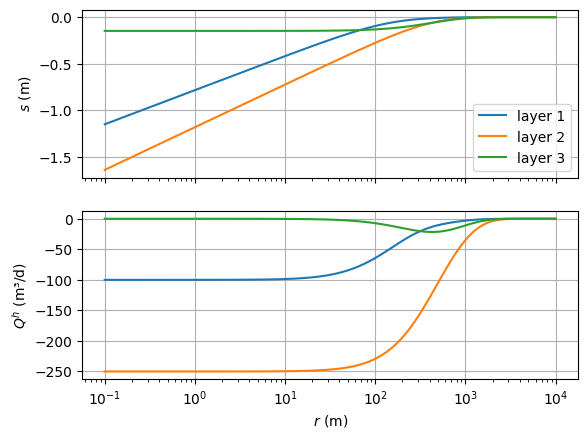

In [20]:
model1 = Steady(T=[100, 200, 50],    # transmissivities (m²/d)
                Q=[-100, -250, 0],   # pumping rates (m³/d)
                c=[500, 1000],       # resistances (d)
                c_top=100)           # top resistance (d)

r = np.logspace(-1, 4, 100)  # radial distances (m)

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.semilogx(r, model1.h(r).T);  # drawdown s (m)
ax1.legend([f'layer {i+1}' for i in range(model1.nl)]);
ax1.set_ylabel('$s$ (m)');
ax1.grid();

ax2.semilogx(r, model1.qh(r).T);  # radial discharge Qh (m³/d)
ax2.set_xlabel('$r$ (m)');
ax2.set_ylabel('$Q^h$ (m³/d)');
ax2.grid();

The same model but now the well has constant heads taken from the previous model:

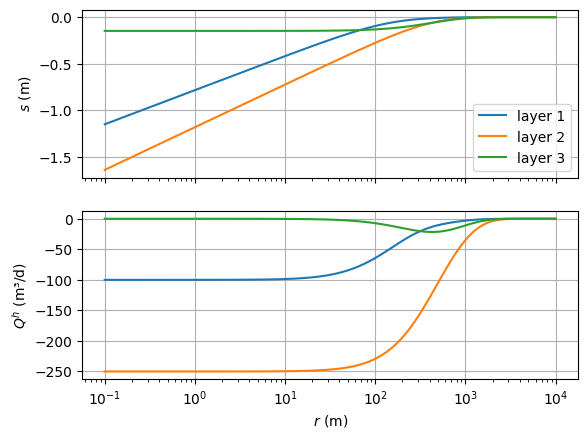

In [21]:
h_in = model1.h(r[0]).squeeze()  # get heads from previous model at distance r = 0.1 m

model2 = Steady(T=[100, 200, 50],  # transmissivities (m²/d)
                h_in=h_in,         # constant heads (m) at the well-face
                r_in=r[0],         # well-radius (m)
                c=[500, 1000],     # resistances (d)
                c_top=100)         # top resistance (d)

r = np.logspace(-1, 4, 100)  # radial distances (m)

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.semilogx(r, model2.h(r).T);  # drawdown s (m)
ax1.legend([f'layer {i+1}' for i in range(model2.nl)]);
ax1.set_ylabel('$s$ (m)');
ax1.grid();

ax2.semilogx(r, model2.qh(r).T);  # radial discharge Qh (m³/d)
ax2.set_xlabel('$r$ (m)');
ax2.set_ylabel('$Q^h$ (m³/d)');
ax2.grid();

We get the same result as it should!

Simulating the evolution of drawdown in the pumping well as a function of time:

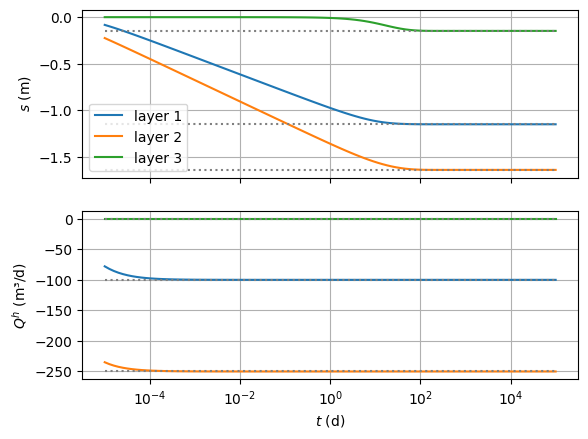

In [22]:
model3 = Transient(T=[100, 200, 50],       # transmissivities (m²/d)
                   S=[0.1, 0.05, 0.01],    # storativities (-)
                   Q=[-100, -250, 0],      # pumping rates (m³/d)
                   c=[500, 1000],          # resistances (d)
                   c_top=100)              # top resistance (d)

r = 0.1  # well-radius (m)
t = np.logspace(-5, 5, 100)  # simulation times (d)

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.semilogx(t, model3.h(r, t).squeeze().T);  # drawdown s (m)
ax1.semilogx(t[[0, -1]], model1.h([r, r]).T, color='gray', linestyle=':');  # steady-state drawdown
ax1.legend([f'layer {i+1}' for i in range(model1.nl)]);
ax1.set_ylabel('$s$ (m)');
ax1.grid();

ax2.semilogx(t, model3.qh(r, t).squeeze().T);  # radial discharge Qh (m³/d)
ax2.semilogx(t[[0, -1]], model1.qh([r, r]).T, color='gray', linestyle=':');  # steady-state discharge
ax2.set_xlabel('$t$ (d)');
ax2.set_ylabel('$Q^h$ (m³/d)');
ax2.grid();

Steady state is reached after approximately 100 days of pumping.

Note that the pumping rates $Q$ are negative, as are the drawdowns $s$ and the radial discharges $Q^h$. Infiltration flux $N$ is positive (see examples below).

### Parallel flow

Steady-state two-layer model simulating parallel flow away from an irrigating constant-head river. There is also recharge and drainage.

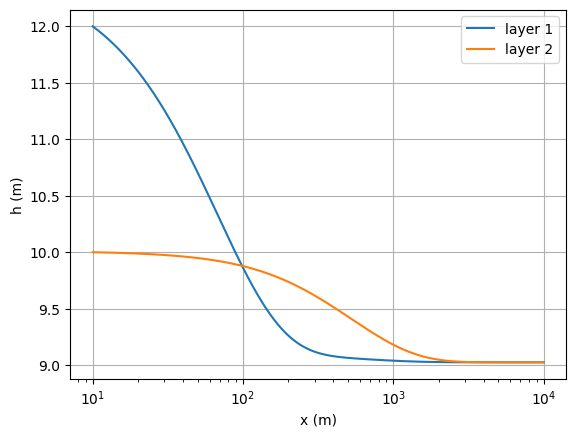

In [23]:
# The river level is 12 m, the drainage level is 9 m.

model4 = Steady(T=[100, 500],     # aquifer transmissivities (m²/d)
                c=500,            # aquitard resistance (d)
                N=[5e-4, 0],      # infiltration (m/d)
                c_top=50,         # drainage resistance (d)
                h_top=9,          # drainage level (m)
                r_in=10,          # river half-width (m)
                h_in=[12, 10],    # constant heads (m) at inner boundary (with river level)
                h_out=[10, 10],   # constant heads (m) at infinity
                axi=False)        # parallel flow!

r = np.logspace(1, 4, 1000)       # horizontal distances (m)

plt.semilogx(r, model4.h(r).T);   # heads (m)
plt.legend([f'layer {i+1}' for i in range(model4.nl)]);
plt.grid();
plt.xlabel('x (m)');
plt.ylabel('h (m)');

## Well-known analytical solutions

The known analytical solution is always represented by colored solid lines, the generalized solution by black dotted lines.

### Darcy's law

Darcy's (1856) law:

> $Q = T \dfrac{h - h_{out}}{r_{out} - r}$

Note that in this case, $Q$ has dimension L³/T/L.

Rearranging into **Equation 115** (Section 2.5.1):

> $h = h_{out} + \dfrac{Q}{T} (r_{out} - r)$

Defining head change $s$ [L]:

> $s(r) = h(r) - h_{out}$

Rearranging into dimensionless form:

> $\dfrac{sT}{Qr_{out}} = 1 - \dfrac{r}{r_{out}}$


This solution is implemented in function `darcy`.

Creating Figure 3 (Section 2.5.1):

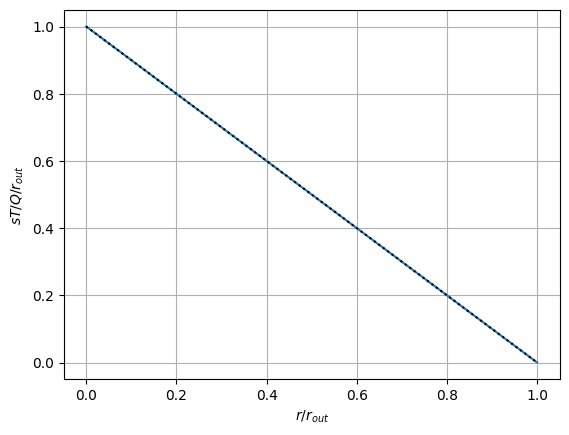

In [24]:
# solution is expressed in dimensionless form
T = Q = r_out = 1
# solution is expressed as a function of (dimensionless) drawdown
h_out = 0

r = [0, 1]  # relative distances

s = darcy(r=r, T=T, Q=Q, r_out=r_out, h_out=h_out)  # dimensionless drawdown
m = Steady(T=T, Q=Q, r_out=r_out, h_out=h_out, axi=False)

plt.plot(r, s, '-',
         r, m.h(r).T, 'k:');
plt.grid();
plt.xlabel('$r/r_{out}$');
plt.ylabel('$sT/Q/r_{out}$');

**Equation 117** (Section 2.5.1):

> $h = \dfrac{h_{in} (r - r_{out}) + h_{out} (r_{in} - r)}{r_{in} - r_{out}}$

Rearranging into dimensionless form:

> $\dfrac{h}{h_{in}} = \dfrac{(r/r_{out} - 1) + h_{out}/h_{in} (r_{in}/r_{out} - r/r_{out})}{r_{in}/r_{out} - 1}$


This solution is implemented in function `parallel_flow`:

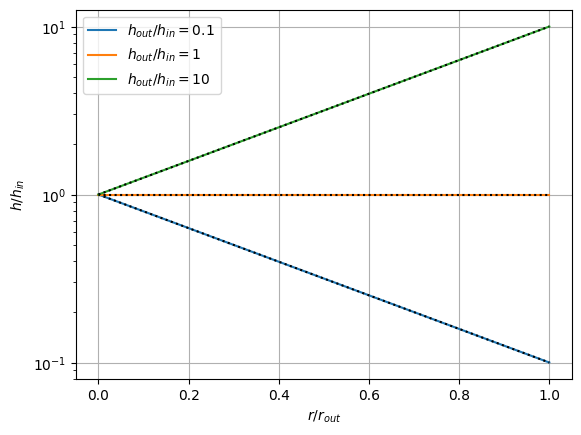

In [25]:
# solution is expressed in dimensionless form
h_in = r_out = 1

r_in = 0  # set r_in to zero
r = [0, 1]  # relative distances r/r_out
constant_heads = [0.1, 1, 10]  # relative constant heads at outer boundary h_out/h_in

for h_out in constant_heads:
    h = parallel_flow(r=r, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out)
    m = Steady(T=1, h_in=h_in, r_in=r_in, r_out=r_out, h_out=h_out, axi=False)
    plt.semilogy(r, h, '-', label='$h_{out}/h_{in}='+str(h_out)+'$');
    plt.semilogy(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel('$r/r_{out}$');
plt.ylabel('$h/h_{in}$');

Creating Figure 4 (Section 2.5.1):

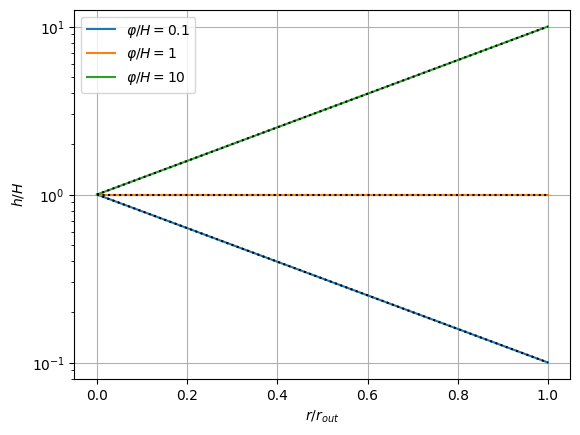

In [26]:
# using symbols defined in chapter 2
h_in = r_out = 1

r_in = 0  # set r_in to zero
r = [0, 1]  # relative distances r/r_out
constant_heads = [0.1, 1, 10]  # relative constant heads at outer boundary h_out/h_in

for h_out in constant_heads:
    h = parallel_flow(r=r, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out)
    m = Steady(T=1, h_in=h_in, r_in=r_in, r_out=r_out, h_out=h_out, axi=False)
    plt.semilogy(r, h, '-', label='$\\varphi /H='+str(h_out)+'$');
    plt.semilogy(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel('$r/r_{out}$');
plt.ylabel('$h/H$');

Note that the generalized solution also requires transmissivity `T`, although the simulated heads are insensitive to it. So the value assigned to `T` doesn't matter here.

### The Thiem-Dupuit equation

The Thiem (1870, 1906) equation (**Equation 118**, Section 2.5.2):

> $h = h_{out} + \dfrac{Q}{2 \pi T} \ln \dfrac{r_{out}}{r}$

Rearranging into dimensionless form:

> $\dfrac{2 \pi Ts}{Q} = \ln \dfrac{r_{out}}{r}$

with $s = h - h_{out}$.


This solution is implemented in function `thiem`.

Creating Figure 5 (Section 2.5.2):

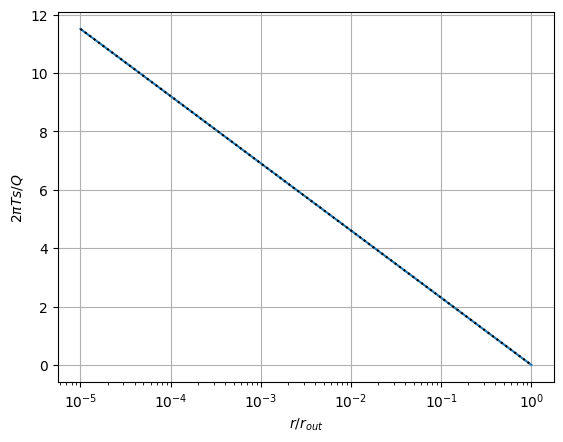

In [27]:
# solution is expressed in dimensionless form
T = r_out = 1
Q = 2 * np.pi

r = np.logspace(-5, 0, 100)  # relative distances r/r_out
s = thiem(r=r, T=T, Q=Q, r_out=r_out)  # dimensionless drawdown
m = Steady(T=T, Q=Q, r_out=r_out)

plt.semilogx(r, s, '-',
             r, m.h(r).T, 'k:');
plt.grid();
plt.xlabel('$r/r_{out}$');
plt.ylabel('$2 \pi Ts/Q$');

**Equation 119** (Section 2.5.2):

> $h = \dfrac{h_{in}\ln(r/r_{out}) + h_{out}\ln(r_{in}/r)}{\ln(r_{in}/r_{out})}$

Rearranging into dimensionless form:

> $\dfrac{h}{h_{in}} = \dfrac{\ln\dfrac{r}{r_{out}} + \dfrac{h_{out}}{h_{in}}\ln\dfrac{r_{in}/r_{out}}{r/r_{out}}}{\ln\dfrac{r_{in}}{r_{out}}}$

This solution is implemented in function `radial_flow`:

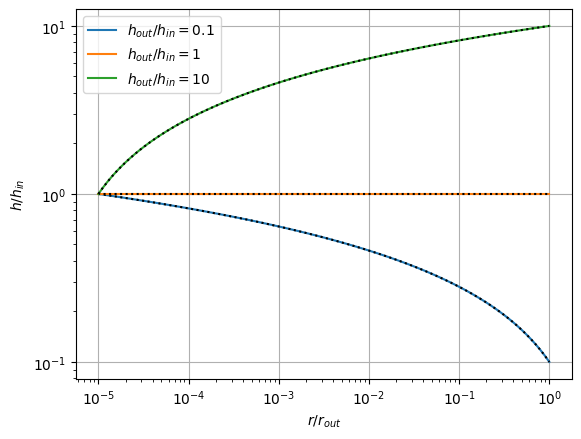

In [28]:
# solution is expressed in dimensionless form
h_in = r_out = 1

r_in = 1e-5  # relative inner boundary distance r_in/r_out
r = np.logspace(np.log10(r_in), np.log10(r_out), 100)  # relative distances r/r_out
constant_heads = [0.1, 1, 10]  # relative constant heads at outer boundary h_out/h_in

for h_out in constant_heads:
    h = radial_flow(r=r, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out)
    m = Steady(T=1, h_in=h_in, r_in=r_in, r_out=r_out, h_out=h_out)
    plt.loglog(r, h, '-', label='$h_{out}/h_{in}='+str(h_out)+'$');
    plt.loglog(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel('$r/r_{out}$');
plt.ylabel('$h/h_{in}$');

Creating Figure 6 (Section 2.5.2):

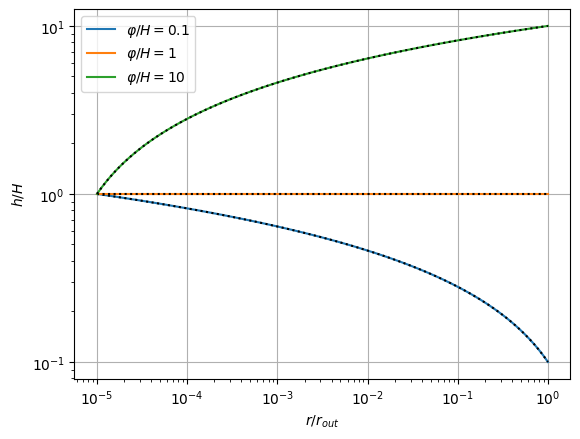

In [29]:
# using symbols defined in Chapter 2
h_in = r_out = 1

r_in = 1e-5  # relative inner boundary distance r_in/r_out
r = np.logspace(np.log10(r_in), np.log10(r_out), 100)  # relative distances r/r_out
constant_heads = [0.1, 1, 10]  # relative constant heads at outer boundary h_out/h_in

for h_out in constant_heads:
    h = radial_flow(r=r, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out)
    m = Steady(T=1, h_in=h_in, r_in=r_in, r_out=r_out, h_out=h_out)
    plt.loglog(r, h, '-', label='$\\varphi/H='+str(h_out)+'$');
    plt.loglog(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel('$r/r_{out}$');
plt.ylabel('$h/H$');

### Areal recharge on a circular island

**Equation 121** (Section 2.5.3):

> $h = h_{out} + \bigg( \dfrac{Nr_{in}^2}{2T} - \dfrac{Q}{2\pi T} \bigg) \ln\dfrac{r}{r_{out}} + \dfrac{N}{4T} \bigg( r_{out}^2 - r^2 \bigg) $

Rearranging into dimensionless form:

> $\dfrac{2\pi Ts}{Q} = \bigg( \dfrac{N \pi r_{out}^2}{Q} \dfrac{r_{in}^2}{r_{out}^2} - 1 \bigg) \ln\dfrac{r}{r_{out}} + \dfrac{N \pi r_{out}^2}{2Q} \bigg( 1 - \dfrac{r^2}{r_{out}^2} \bigg) $

with $s = h - h_{out}$.

This solution is implemented in function `island`:

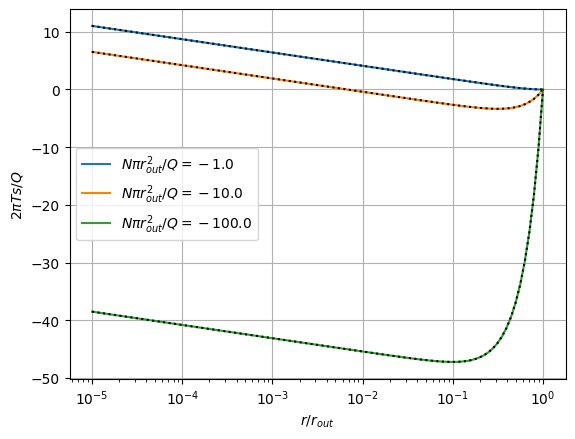

In [30]:
# solution is expressed in dimensionless form
T = r_out = 1
Q = 2 * np.pi

r_in = 1e-5  # relative inner boundary distance r_in/r_out
r = np.logspace(np.log10(r_in), np.log10(r_out), 100)  # relative distances r/r_out
recharge = -np.logspace(0, 2, 3)  # dimensionless recharge

for N in recharge:
    s = island(r=r, T=T, Q=Q, N=N*2, r_in=r_in, r_out=r_out)
    m = Steady(T=T, Q=Q, N=N*2, r_in=r_in, r_out=r_out)
    plt.semilogx(r, s, '-', label='$N\pi r_{out}^2/Q='+str(N)+'$');
    plt.semilogx(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel('$r/r_{out}$');
plt.ylabel('$2\pi Ts/Q$');

Recall that $Q$ is negative in case of pumping and $N$ is positive in case of infiltration. Head change $s$ is negative when the initial head is lowered. So the dimensionless head change $2\pi Ts/Q$ is positive in case of pumping and when the head during pumping is lower than the initial head!

Creating Figure 7 (Section 2.5.3):

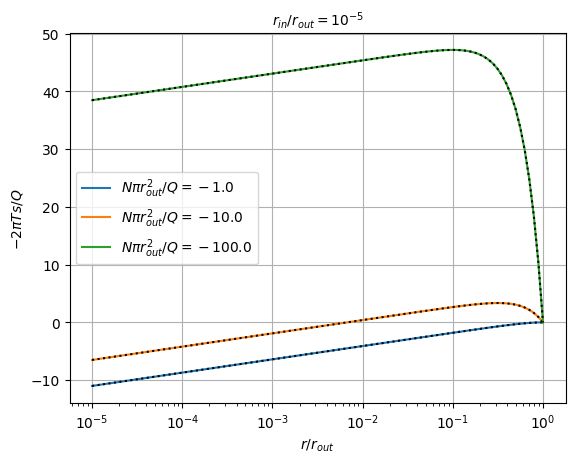

In [31]:
# plot -2*pi*T*s/Q
T = r_out = 1
Q = -2 * np.pi

r_in = 1e-5  # relative inner boundary distance r_in/r_out
r = np.logspace(np.log10(r_in), np.log10(r_out), 100)  # relative distances r/r_out
recharge = np.logspace(0, 2, 3)  # dimensionless recharge

for N in recharge:
    s = island(r=r, T=T, Q=Q, N=N*2, r_in=r_in, r_out=r_out)
    m = Steady(T=T, Q=Q, N=N*2, r_in=r_in, r_out=r_out)
    plt.semilogx(r, s, '-', label='$N\pi r_{out}^2/Q='+str(-N)+'$');
    plt.semilogx(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel('$r/r_{out}$');
plt.ylabel('$-2\pi Ts/Q$');
plt.title('$r_{in}/r_{out}=10^{-5}$', dict(fontsize=10));

### 1D parallel flow with recharge

**Equation 122** (Section 2.5.4):

> $h=\dfrac{h_{in}(r-r_{out})+h_{out}(r_{in}-r)}{r_{in}-r_{out}} + \dfrac{N}{2T}.\dfrac{(r^2_{in}-r^2_{out})r+(r^2_{out}-r^2)r_{in}+(r^2-r^2_{in})r_{out}}{r_{in}-r_{out}}$

Rearranging into dimensionless form:

> $h^*=\dfrac{h^*_{in}(r^*-1)+h^*_{out}(r^*_{in}-r^*)}{r_{in}^*-1} + \dfrac{(r^{*2}_{in}-1)r+(1-r^{*2})r^*_{in}+(r^{*2}-r^{*2}_{in})}{r^*_{in}-1}$

with:

> $h^*= (2Th) / (Nr^2_{out})$

> $h^*_{in}= (2Th_{in}) / (Nr^2_{out})$

> $h_{out}^*= (2Th_{out}) / (Nr^2_{out})$

> $r^*=r / r_{out}$

> $r_{in}^*=r_{in} / r_{out}$

This solution is implemented in function `parallel_flow`:

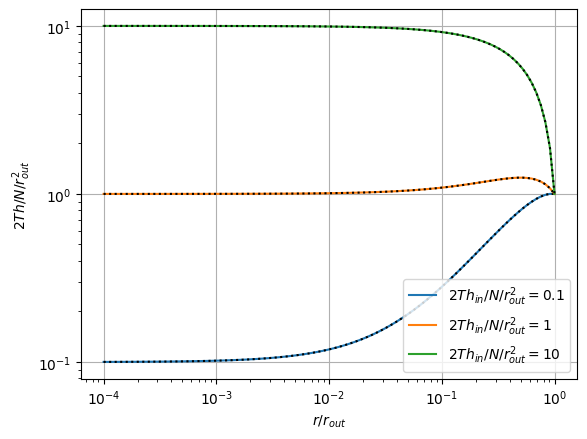

In [32]:
# solution is expressed in dimensionless form
T = r_out = h_out = 1
N = 2

r_in = 1e-4  # relative inner model boundary distance r_in/r_out
r = np.logspace(np.log10(r_in), np.log10(r_out), 100)  # relative distances r/r_out
constant_heads = [0.1, 1, 10]  # dimensionless constant heads at inner model boundary

for h_in in constant_heads:
    h = parallel_flow(r=r, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out, T=T, N=N)  # dimensionless head
    m = Steady(T=T, N=N, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out, axi=False)
    plt.loglog(r, h, '-', label="$2Th_{in}/N/r^2_{out}="+str(h_in)+"$");
    plt.loglog(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel("$r/r_{out}$");
plt.ylabel("$2Th/N/r^2_{out}$");

Creating Figure 8 (Section 2.5.4):

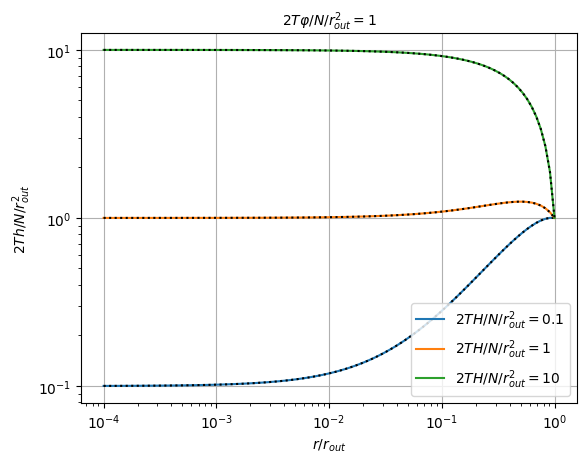

In [33]:
# using the symbols defined in chapter 2
T = r_out = h_out = 1
N = 2

r_in = 1e-4  # relative inner model boundary distance r_in/r_out
r = np.logspace(np.log10(r_in), np.log10(r_out), 100)  # relative distances r/r_out
constant_heads = [0.1, 1, 10]  # dimensionless constant heads at inner model boundary

for h_in in constant_heads:
    h = parallel_flow(r=r, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out, T=T, N=N)  # dimensionless head
    m = Steady(T=T, N=N, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out, axi=False)
    plt.loglog(r, h, '-', label="$2TH/N/r^2_{out}="+str(h_in)+"$");
    plt.loglog(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel("$r/r_{out}$");
plt.ylabel("$2Th/N/r^2_{out}$");
plt.title("$2T\\varphi/N/r^2_{out}=1$", dict(fontsize=10));

### 1D axisymmetric flow with recharge

**Equation 122** (Section 2.5.4):

> $h=\dfrac{h_{in}\ln(r/r_{out})+h_{out}\ln(r_{in}/r)}{\ln(r_{in}/r_{out})} + \dfrac{N}{4T} \dfrac{(r^2_{in}-r^2_{out})\ln(r)+(r^2_{out}-r^2)\ln(r_{in})+(r^2-r^2_{in})\ln(r_{out})}{\ln(r_{in}/r_{out})}$

Rearranging into dimensionless form:

> $h^*=\dfrac{h^*_{in}\ln(r^*)+h^*_{out}\ln(r^*_{in}/r^*) + (r^{*2}_{in}-1)\ln(r^*)+(1-r^{*2})\ln(r^*_{in})}{\ln(r^*_{in})}$

with:

> $h^*= (4Th) / (Nr^2_{out})$

> $h^*_{in}= (4Th_{in}) / (Nr^2_{out})$

> $h_{out}^*= (4Th_{out}) / (Nr^2_{out})$

> $r^*=r / r_{out}$

> $r_{in}^*=r_{in} / r_{out}$

This solution is implemented in function `radial_flow`:

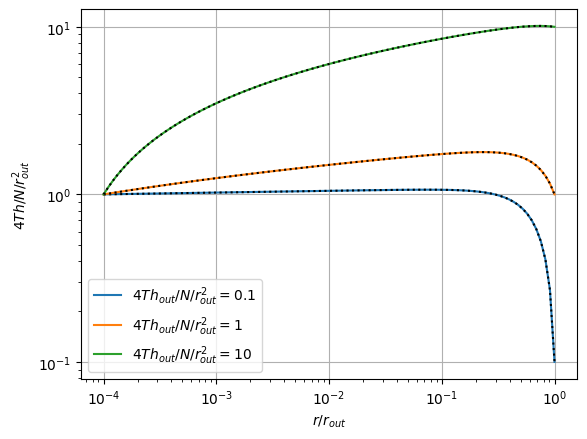

In [34]:
# solution is expressed in dimensionless form
T = r_out = h_in = 1
N = 4

r_in = 1e-4  # relative inner model boundary distance r_in/r_out
r = np.logspace(np.log10(r_in), np.log10(r_out), 100)  # relative distances r/r_out
constant_heads = [0.1, 1, 10]  # dimensionless constant heads at outer model boundary

for h_out in constant_heads:
    h = radial_flow(r=r, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out, T=T, N=N)  # dimensionless head
    m = Steady(T=T, N=N, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out)
    plt.loglog(r, h, '-', label="$4Th_{out}/N/r^2_{out}="+str(h_out)+"$");
    plt.loglog(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel("$r/r_{out}$");
plt.ylabel("$4Th/N/r^2_{out}$");

Creating Figure 9 (Section 2.5.5):

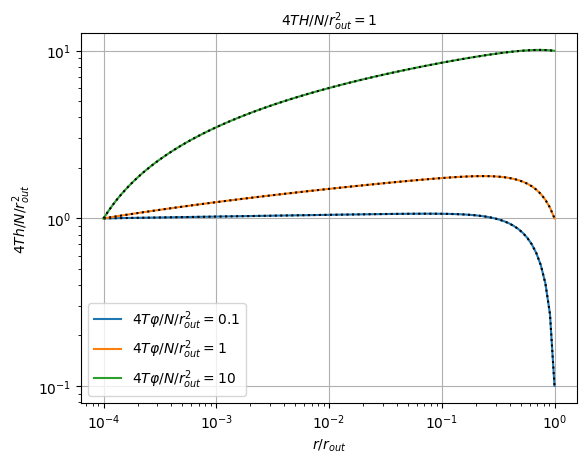

In [35]:
# using the symbols defined in chapter 2
T = r_out = h_in = 1
N = 4

r_in = 1e-4  # relative inner model boundary distance r_in/r_out
r = np.logspace(np.log10(r_in), np.log10(r_out), 100)  # relative distances r/r_out
constant_heads = [0.1, 1, 10]  # dimensionless constant heads at outer model boundary

for h_out in constant_heads:
    h = radial_flow(r=r, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out, T=T, N=N)  # dimensionless head
    m = Steady(T=T, N=N, r_in=r_in, h_in=h_in, r_out=r_out, h_out=h_out)
    plt.loglog(r, h, '-', label="$4T\\varphi /N/r^2_{out}="+str(h_out)+"$");
    plt.loglog(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel("$r/r_{out}$");
plt.ylabel("$4Th/N/r^2_{out}$");
plt.title("$4TH/N/r^2_{out}=1$", dict(fontsize=10));

### The de Glee equation

The de Glee (1930) formula (**Equation 126**, Section 2.5.6):

> $h = h_{top} + \dfrac{Q}{2\pi T} \text{K}_0(r/\sqrt{Tc_{top}})$

Rearranging into dimensionless form:

> $\dfrac{2\pi Ts}{Q} = \text{K}_0 (r/\sqrt{Tc_{top}})$

with $s = h - h_{top}$

This solution is implemented in function `deglee`:

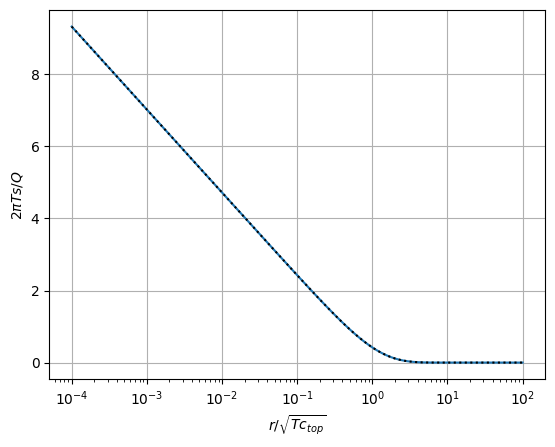

In [36]:
# solution is expressed in dimensionless form
T = c_top = 1
Q = 2 * np.pi

r = np.logspace(-4, 2, 100)  # dimensionless distance r/sqrt(T*c_top)

s = deglee(r=r, T=T, Q=Q, c_top=c_top)  # dimensionless drawdown
m = Steady(T=T, Q=Q, c_top=c_top)

plt.semilogx(r, s, '-');
plt.semilogx(r, m.h(r).T, 'k:');
plt.grid();
plt.xlabel('$r/\sqrt{Tc_{top}}$');
plt.ylabel('$2\pi Ts/Q$');

**Equation 128** (Section 2.5.6):

> $h = h_{top} + \dfrac{Q}{2\pi T} \dfrac{K_0(r/\sqrt{Tc_{top}})}{(r_{in}/\sqrt{Tc_{top}})K_1(r_{in}/\sqrt{Tc_{top}})}$

Rearranging into dimensionless form:

> $\dfrac{2\pi Ts}{Q} = \dfrac{K_0(r/\sqrt{Tc_{top}})}{(r_{in}/\sqrt{Tc_{top}})K_1(r_{in}/\sqrt{Tc_{top}})}$

with $s = h - h_{top}$

This solution is also implemented in function `deglee`.

Creating Figure 10 (Section 2.5.6):

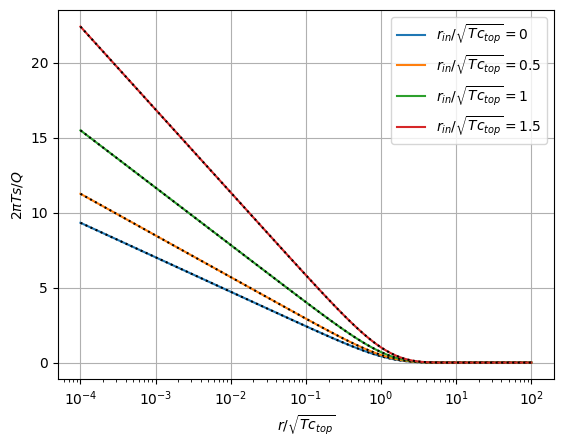

In [37]:
# solution is expressed in dimensionless form
T = c_top = 1
Q = 2 * np.pi

inner_radii = [0, 0.5, 1, 1.5]  # dimensionless well-radius r_in/sqrt(T*c_top)
r = np.logspace(-4, 2, 100)  # dimensionless distance r/sqrt(T*c_top)

for r_in in inner_radii:
    s = deglee(r=r, T=T, Q=Q, c_top=c_top, r_in=r_in);  # dimensionless drawdown
    m = Steady(T=T, Q=Q, c_top=c_top, r_in=r_in);
    plt.semilogx(r, s, '-', label="$r_{in}/\sqrt{Tc_{top}}="+str(r_in)+"$");
    plt.semilogx(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel('$r/\sqrt{Tc_{top}}$');
plt.ylabel('$2\pi Ts/Q$');

Note that the blue curve corresponds to the de Glee (1930) solution for infinitesimal well-radius shown in previous plot.

**Equation 129** (Section 2.5.6):

> $h = \dfrac{h_{top}c_{bot}+h_{bot}c_{top}}{c_{top}+c_{bot}} + \dfrac{Q}{2\pi T} \dfrac{K_0(r/\lambda )}{(r_{in}/\lambda)K_1(r_{in}/\lambda)}$

with $\lambda = \sqrt{\dfrac{c_{top}c_{bot}T}{c_{top}+c_{bot}}}$

Rearranging into dimensionless form:

> $h^* = h^*_{top}c^*_{bot}+h^*_{bot}c^*_{top} + \dfrac{K_0(r^*/\sqrt{c^*_{top}c^*_{bot}})}{(r_{in}^*/\sqrt{c^*_{top}c^*_{bot}})K_1(r_{in}^*/\sqrt{c^*_{top}c^*_{bot}})}$

with:
> $h^*=2\pi Th/Q$

> $h^*_{top}=2\pi Th_{top}/Q$

> $h^*_{bot}=2\pi Th_{bot}/Q$

> $c^*_{top} = c_{top}/(c_{top}+c_{bot})$

> $c^*_{bot} = c_{bot}/(c_{top}+c_{bot})$

> $r^* = r / \sqrt{T(c_{top}+c_{bot})}$

> $r^*_{in} = r_{in} / \sqrt{T(c_{top}+c_{bot})}$

This solution is also implemented in function `deglee`.

Creating Figure 11 (Section 2.5.6):

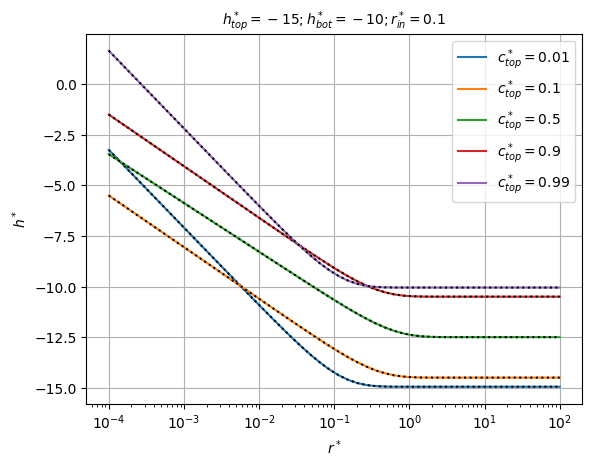

In [38]:
# solution is expressed in dimensionless form
T = 1
Q = 2 * np.pi

r_in = 0.1  # dimensionless well-radius
r = np.logspace(-4, 2)  # dimensionless distances
h_top = -15  # dimensionless constant head at upper boundary
h_bot = -10  # dimensionless constant head at lower boundary
resistances = [0.01, 0.1, 0.5, 0.9, 0.99]  # dimensionless resistances at upper boundary

for c_top in resistances:
    c_bot = 1 - c_top  # dimensionless resistance at lower boundary
    h = deglee(r=r, T=T, Q=Q, c_top=c_top, h_top=h_top, c_bot=c_bot, h_bot=h_bot, r_in=r_in)  # dimensionless head
    m = Steady(T=T, Q=Q, c_top=c_top, h_top=h_top, c_bot=c_bot, h_bot=h_bot, r_in=r_in)
    plt.semilogx(r, h, '-', label='$c^*_{top}='+str(c_top)+'$');
    plt.semilogx(r, m.h(r).T, 'k:');

plt.legend();
plt.grid();
plt.xlabel('$r^*$');
plt.ylabel('$h^*$');
plt.title('$h^*_{top}=-15; h^*_{bot}=-10; r^*_{in}=0.1$', fontdict=dict(fontsize=10));

Note that constant heads $h_{top}$ and $h_{bot}$ are negative as pumping rate $Q$ is lower than zero when water is extracted.

### The Theis equation

The Theis (1935) solution (**Equation 132**, Section 2.5.7):

> $h = h_0 + \dfrac{Q}{4\pi T} \text{W}\bigg(\dfrac{r^2S}{4tT}\bigg)$

Rearranging into dimensionless form:

> $\dfrac{4\pi Ts}{Q} = \text{W}\bigg(\dfrac{r^2S}{4tT}\bigg)$

with $s(r,t) = h(r,t) - h_0$.

This solution is implemented in function `theis`.

Creating Figure 12 (Section 2.5.7):

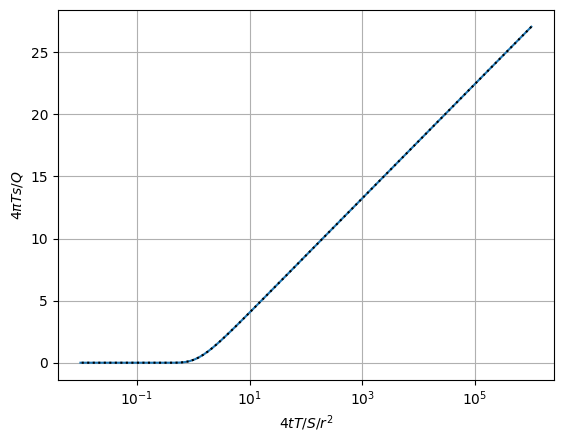

In [39]:
# solution is expressed in dimensionless form
T = S = 1
Q = 4 * np.pi
t = 1 / 4

r = np.logspace(-6, 2, 100)  # dimensionless distance r*sqrt(S/4/t/T)

s = theis(r=r, t=t, T=T, S=S, Q=Q)  # dimensionless drawdown
m = Transient(T=T, S=S, Q=Q)

plt.semilogx(1/r, s.squeeze(), '-');
plt.semilogx(1/r, m.h(r, t).squeeze(), 'k:');
plt.grid();
plt.xlabel('$4tT/S/r^2$');
plt.ylabel('$4\pi Ts/Q$');

The Theis (1935) recovery solution (**Equation 134**, Section 2.5.7):

> $s' = \dfrac{Q}{4\pi T} \bigg[W\bigg(\dfrac{r^2S}{4tT}\bigg) - W\bigg(\dfrac{r^2S}{4T(t-\tau)}\bigg)\bigg]$

Rearranging into dimensionless form:

> $\dfrac{4\pi Ts'}{Q} = \bigg[W\bigg(\dfrac{1}{t^*}\bigg) - W\bigg(\dfrac{1}{t^*-\tau^*}\bigg)\bigg]$

with:

> $t^* = (4tT)/(r^2S)$

> $\tau^* = (4\tau T)/(r^2S)$


This solution can be simulated applying superposition and using function `theis`:

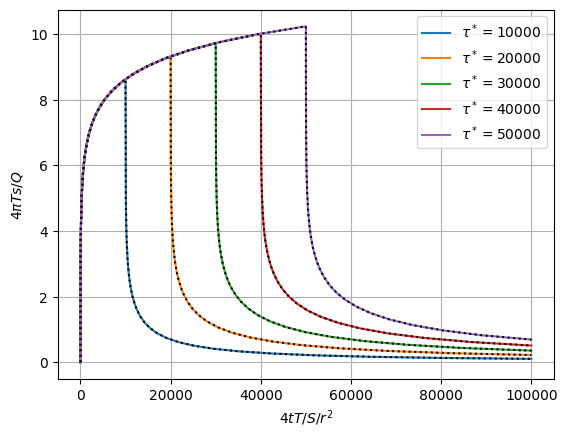

In [40]:
# solution is expressed in dimensionless form
T = S = 1
Q = 4 * np.pi
r = 2

t1, t2 = 1e-6, 1e5  # dimensionless time: 4*t*T/S/r**2 (start and end)
n = 100  # number of simulation times per stress period

m = Transient(T=T, S=S, Q=Q)  # instantiate Transient model

for tau in [1e4, 2e4, 3e4, 4e4, 5e4]:  # dimensionless times at which recovery starts: 4*tau*T/S/r**2

    t_pump = np.logspace(np.log10(t1), np.log10(tau), n)  # pumping period (t < tau)
    t_reco = np.logspace(np.log10(t1), np.log10(t2 - tau), n)  # recovery period (t > tau)
    t = np.hstack((t_pump, tau + t_reco[1:]))  # total simulation period (dimensionless times)

    s = theis(r=r, t=t, T=T, S=S, Q=Q).squeeze()  # dimensionless drawdown due to pumping
    s_reco = theis(r=r, t=t_reco, T=T, S=S, Q=-Q).squeeze()  # dimensionless head change due to recovery
    s[-n:] += s_reco  # superposition
    plt.plot(t, s, '-', label='$ \\tau^* ='+str(int(tau))+'$');

    s = m.h(r=r, t=t).squeeze()
    s_reco = m.h(r=r, t=t_reco).squeeze()
    s[-n:] -= s_reco
    plt.plot(t, s, 'k:');

plt.legend();
plt.grid();
plt.xlabel('$4tT/S/r^2$');
plt.ylabel("$4\pi Ts/Q$");

Note that the residual drawdown $s'$ is observed after the pump has been shut down, that is if $t > \tau$.

Interesting is the case where the elastic storage changes during recovery (Theis, 1935; Kruseman & de Ridder, 1990):

> $s' = \dfrac{Q}{4\pi T} \bigg[W\bigg(\dfrac{r^2S_1}{4tT}\bigg) - W\bigg(\dfrac{r^2S_2}{4T(t-\tau)}\bigg)\bigg]$

with $S_1$ and $S_2$ the storativities during pumping and recovery, resp.

Rearranging into dimensionless form:

> $\dfrac{4\pi Ts'}{Q} = \bigg[W\bigg(\dfrac{1}{t^*}\bigg) - W\bigg(\dfrac{S^*}{t^*-\tau^*}\bigg)\bigg]$

with:

> $t^* = (4tT)/(r^2S_1)$

> $\tau^* = (4\tau T)/(r^2S_1)$

> $S^* = S_2/S_1$


This solution is implemented in function `theis_recovery`:

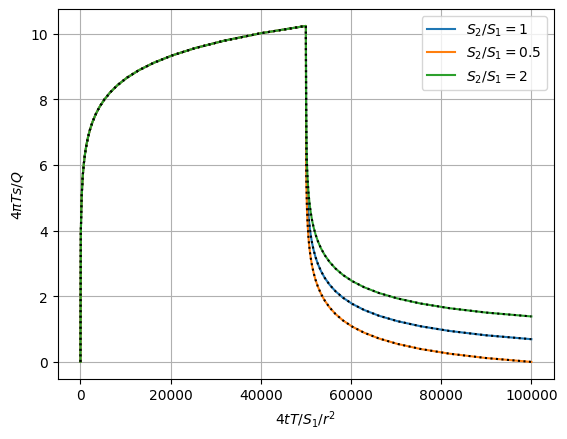

In [41]:
# solution is expressed in dimensionless form
T = S1 = 1
Q = 4 * np.pi
r = 2

tau = 50_000  # dimensionless time when pumping stops
n = 100  # number of simulation times for each phase
dt = np.logspace(-5, np.log10(tau), n)  # discretization of pumping and recovery phase
t = np.hstack((dt, tau + dt))  # dimensionless times

# simulating pumping for entire simulation period
m = Transient(T=T, S=S1, Q=Q)
s_pump = m.h(r=r, t=t).flatten()

for S2 in [1, 0.5, 2]:  # relative storativity S2/S1 during recovery

    # simulating test using function theis_recovery
    s = theis_recovery(r=r, t=t, T=T, S=S1, Q=Q, t_end=tau, S2=S2)  # dimensionless drawdown
    plt.plot(t, s.T, '-', label="$S_2/S_1="+str(S2)+"$");

    # simulating injection for recovery phase
    m = Transient(T=T, S=S2, Q=-Q)
    s_reco = m.h(r=r, t=dt).flatten()
    # applying superposition
    s = s_pump.copy()
    s[-n:] += s_reco
    plt.plot(t, s.T, 'k:');

plt.grid();
plt.legend();
plt.xlabel('$4tT/S_1/r^2$');
plt.ylabel('$4\pi Ts/Q$');

Creating Figure 13 (Section 2.5.7):

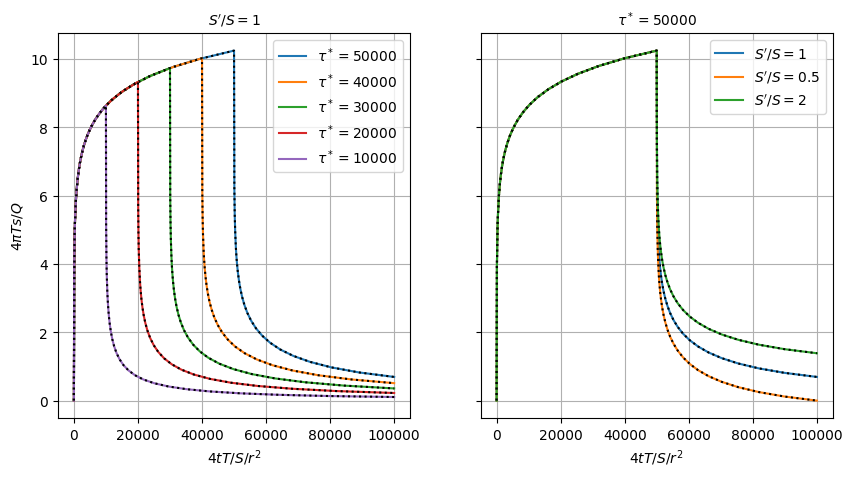

In [42]:
# solution is expressed in dimensionless form
T = S = 1
Q = 4 * np.pi
r = 2

n = 100  # number of simulation times per stress period

m = Transient(T=T, S=S, Q=Q)  # instantiate Transient model

_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5));  # create two subplots

# EQUAL S

t1, t2 = 1e-6, 1e5  # dimensionless time: 4*t*T/S/r**2 (start and end)

for tau in [5e4, 4e4, 3e4, 2e4, 1e4]:  # dimensionless times at which recovery starts: 4*tau*T/S/r**2

    t_pump = np.logspace(np.log10(t1), np.log10(tau), n)  # pumping period (t < tau)
    t_reco = np.logspace(np.log10(t1), np.log10(t2 - tau), n)  # recovery period (t > tau)
    t = np.hstack((t_pump, tau + t_reco[1:]))  # total simulation period (dimensionless times)

    s = theis(r=r, t=t, T=T, S=S, Q=Q).squeeze()  # dimensionless drawdown due to pumping
    s_reco = theis(r=r, t=t_reco, T=T, S=S, Q=-Q).squeeze()  # dimensionless head change due to recovery
    s[-n:] += s_reco  # superposition
    ax1.plot(t, s, '-', label='$ \\tau^* ='+str(int(tau))+'$');

    s = m.h(r=r, t=t).squeeze()
    s_reco = m.h(r=r, t=t_reco).squeeze()
    s[-n:] -= s_reco
    ax1.plot(t, s, 'k:');

ax1.legend();
ax1.grid();
ax1.set_xlabel('$4tT/S/r^2$');
ax1.set_ylabel("$4\pi Ts/Q$");
ax1.set_title("$S'/S=1$", dict(fontsize=10));

# DIFFERENT S

tau = 50_000  # dimensionless time when pumping stops
dt = np.logspace(-5, np.log10(tau), n)  # discretization of pumping and recovery phase
t = np.hstack((dt, tau + dt))  # dimensionless times

# simulating pumping for entire simulation period
s_pump = m.h(r=r, t=t).flatten()

for S2 in [1, 0.5, 2]:  # relative storativity S'/S during recovery

    # simulating test using function theis_recovery
    s = theis_recovery(r=r, t=t, T=T, S=S1, Q=Q, t_end=tau, S2=S2)  # dimensionless drawdown
    ax2.plot(t, s.T, '-', label="$S'/S="+str(S2)+"$");

    # simulating injection for recovery phase
    m = Transient(T=T, S=S2, Q=-Q)
    s_reco = m.h(r=r, t=dt).flatten()
    # applying superposition
    s = s_pump.copy()
    s[-n:] += s_reco
    ax2.plot(t, s.T, 'k:');

ax2.grid();
ax2.legend();
ax2.set_xlabel('$4tT/S/r^2$');
ax2.set_title('$\\tau^*='+str(tau)+'$', dict(fontsize=10));

### Effect of a well on the flow of a nearby stream

The effect of a nearby constant-head boundary on a pumping well can be simulated by defining an image injection well (Theis, 1941). This results in **Equation 135** (Section 2.5.8):

> $s = \dfrac{Q}{4\pi T} \bigg[\text{W}\bigg(\dfrac{[x^2 + y^2]S}{4tT}\bigg) - \text{W}\bigg(\dfrac{[(x+2L)^2 + y^2]S}{4tT}\bigg)\bigg]$

Rearranging into dimenionless form:

> $s^* = \bigg[\text{W}\bigg(\dfrac{x^{*2} + y^{*2}}{t^*}\bigg) - \text{W}\bigg(\dfrac{(x^*+2)^2 + y^{*2}}{t^*}\bigg)\bigg]$

with:

> $s^* = (4\pi Ts)/Q$

> $t^* = (4tT)/(SL^2)$

> $x^* = x/L$

> $y^* = y/L$

This solution can be simulated applying superposition (Theis, 1941) and using function `theis`.

Creating the left plot in Figure 14 (Section 2.5.8):

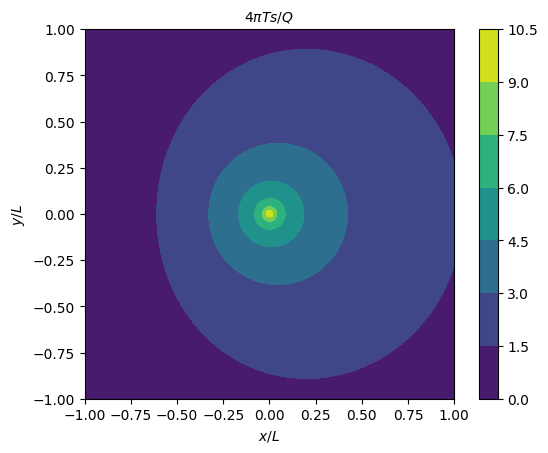

In [43]:
# solution is expressed in dimensionless form
S = T = L = 1
Q = 4 * np.pi
t = 10 / 4  # dimensionless time t* = 10

x_pump, y_pump = 0, 0  # pumping well coordinates: (0, 0)
x_im, y_im = -2*L, 0   # image injection well coordinates: (-2L, 0)

x = y = np.linspace(-L, L, 100)     # x and y coordinates
x_grid, y_grid = np.meshgrid(x, y)  # grid coordinates

r_pump = np.sqrt((x_grid - x_pump)**2 + (y_grid - y_pump)**2)  # distances to pumping well
s_pump = theis(r=r_pump.flatten(), t=t, T=T, S=S, Q=Q);  # dimensionless drawdown due to pumping

r_im = np.sqrt((x_grid - x_im)**2 + (y_grid - y_im)**2)  # distances to injection well
s_im = theis(r=r_im.flatten(), t=t, T=T, S=S, Q=-Q);  # dimensionless head change due to injection

plt.contourf(x_grid, y_grid, np.reshape(s_pump + s_im, x_grid.shape));
plt.colorbar()
plt.gca().set_aspect('equal');
plt.xlabel('$x/L$');
plt.ylabel('$y/L$');
plt.title('$4\pi Ts/Q$', fontdict=dict(fontsize=10));

Storage change (**Equation 143**, Section 2.5.8):

> $\dfrac{dV}{dt} = \dfrac{Q}{2} \bigg[ \text{erf} \bigg( - \sqrt{\dfrac{SL^2}{4tT}} \bigg) - \text{erf} \bigg( \sqrt{\dfrac{SL^2}{4tT}} \bigg) \bigg]$

Rearranging into dimensionless form:

> $\dfrac{dV/dt}{Q} = \dfrac{1}{2} \bigg[ \text{erf} \bigg( - \sqrt{\dfrac{1}{t^*}} \bigg) - \text{erf} \bigg( \sqrt{\dfrac{1}{t^*}} \bigg) \bigg]$

Creating the right plot in Figure 14 (Section 2.5.8):

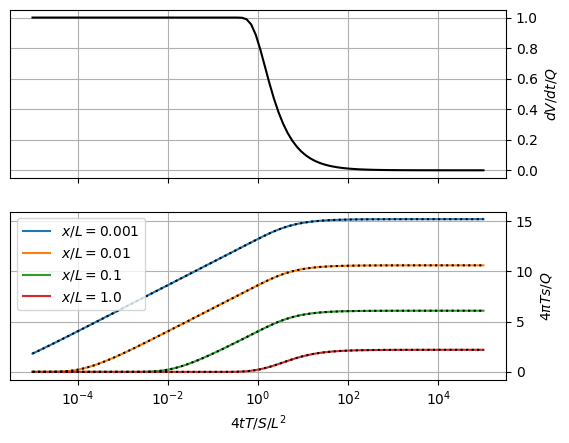

In [44]:
t = np.logspace(-5, 5, 100)  # dimensionless time 4*t*T/S/L**2
dVdt = -(erf(-1/t) - erf(1/t)) / 2  # relative storage change dV/dt/Q

# dimensionless drawdown in point (x/L, y/L)
x = np.logspace(-3, 0, 4)
y = 0
s1 = [exp1((x**2 + y**2) / t) - exp1(((x+2*L)**2 + y**2) / t) for x in x]
m = Transient(T=T, S=S, Q=Q)
s2 = [(m.h(r=x, t=t/4) - m.h(r=x+2*L, t=t/4)).squeeze() for x in x]

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True);

ax1.semilogx(t, dVdt, 'k-');
ax1.grid();
ax1.set_ylabel('$dV/dt/Q$');
ax1.yaxis.tick_right();
ax1.yaxis.set_label_position("right");

ax2.semilogx(t, np.array(s1).T, '-');
ax2.semilogx(t, np.array(s2).T, 'k:');
ax2.grid()
ax2.set_xlabel('$4tT/S/L^2$');
ax2.set_ylabel('$4\pi Ts/Q$');
ax2.legend(['$x/L='+str(x)+'$' for x in x]);
ax2.yaxis.tick_right();
ax2.yaxis.set_label_position("right");

Storage change approximates zero when the dimensionless time $t^*$ is 100, and it is seen the drawdown curves virtually are horizontal lines if $t^* > 100$ indeed.

### The Edelman equations

Edelman (1947) equation "case 0" (**Equation 145**, Section 2.5.9):

> $h = h_0 + (h_{in}-h_0) \text{ erfc} \bigg( r \sqrt{\dfrac{S}{4tT}} \bigg)$

Rearranging into dimensionless form:

> $\dfrac{s}{s_{in}} = \text{ erfc} \bigg( r \sqrt{\dfrac{S}{4tT}} \bigg)$

with $s = h - h_0$ and $s_{in} = h_{in} - h_0$

This solution is implemented in function `edelman`:

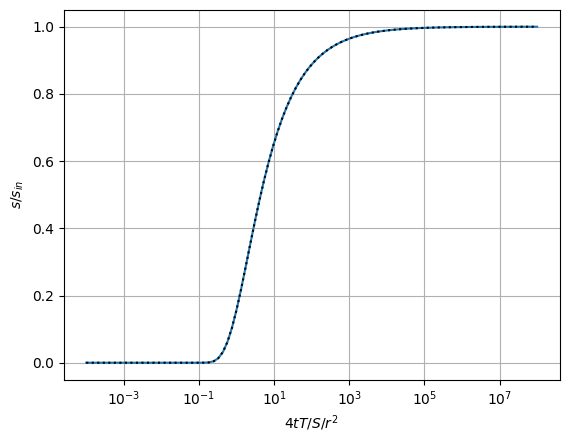

In [45]:
# solution is expressed in dimensionless form
T = S = h_in = 1
r = 2

t = np.logspace(-4, 8, 100)  # dimensionless time 4*t*T/S/r**2
s = edelman(r=r, t=t, T=T, S=S, h_in=h_in)  # dimensionless head change s/s_in
plt.semilogx(t, s.T, '-');

m = Transient(T=T, S=S, h_in=h_in, axi=False)
plt.semilogx(t, m.h(r=r, t=t).squeeze(), 'k:');

plt.grid()
plt.xlabel('$4tT/S/r^2$');
plt.ylabel('$s/s_{in}$');

Edelman (1947) equation "case 1" (**Equation 147**, Section 2.5.9):

> $h = h_0 + 2Q\sqrt{\dfrac{t}{\pi ST}} \text{ exp} \bigg(\dfrac{-r^2S}{4tT}\bigg) - \dfrac{Qr}{T} \text{ erfc} \bigg( r \sqrt{\dfrac{S}{4tT}} \bigg)$

Rearranging into dimensionless form:

> $s^* = \sqrt{\dfrac{t^*}{\pi}}e^{-1/t^*} - \text{ erfc} \bigg( \sqrt{\dfrac{1}{t^*}} \bigg)$

with:

> $s^* = (h - h_0)T/(Qr) = (sT)/(Qr)$

> $t^* = (4tT)/(r^2S)$

This solution is also implemented in function `edelman`:

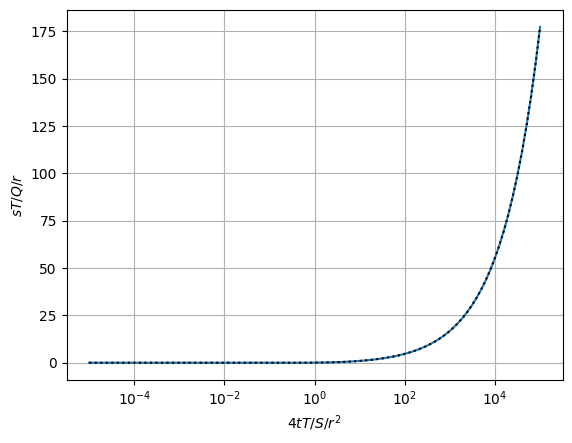

In [46]:
# solution is expressed in dimensionless form
T = S = Q = r = 1

t = np.logspace(-5, 5, 100)  # dimensionless time 4tT/S/r**2
s = edelman(r=r, t=t/4, T=T, S=S, Q=Q)
plt.semilogx(t, s.T);

m = Transient(T=T, S=S, Q=Q, axi=False)
plt.semilogx(t, m.h(r, t/4).squeeze(), 'k:');

plt.grid();
plt.xlabel('$4tT/S/r^2$');
plt.ylabel('$sT/Q/r$');

Creating Figure 15 (Section 2.5.9):

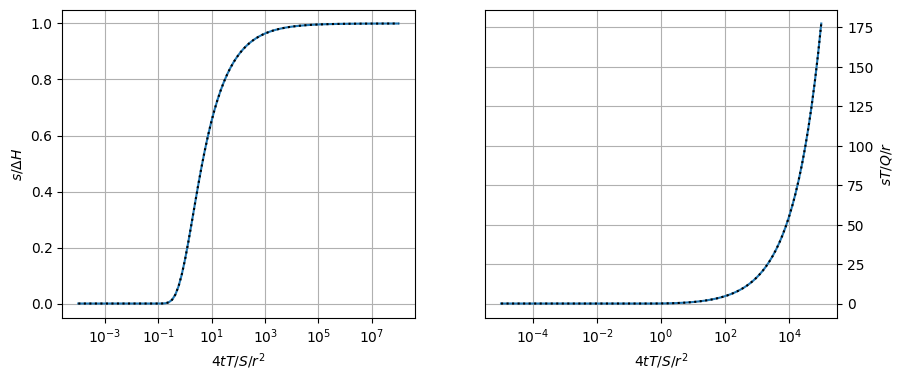

In [47]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# HEAD CHANGE
T = S = h_in = 1
r = 2

t = np.logspace(-4, 8, 100)  # dimensionless time 4*t*T/S/r**2
s = edelman(r=r, t=t, T=T, S=S, h_in=h_in)  # dimensionless head change s/s_in
ax1.semilogx(t, s.T, '-');

m = Transient(T=T, S=S, h_in=h_in, axi=False)
ax1.semilogx(t, m.h(r=r, t=t).squeeze(), 'k:');

ax1.grid()
ax1.set_xlabel('$4tT/S/r^2$');
ax1.set_ylabel('$s/\Delta H$');

# DISCHARGE
T = S = Q = r = 1

t = np.logspace(-5, 5, 100)  # dimensionless time 4tT/S/r**2
s = edelman(r=r, t=t/4, T=T, S=S, Q=Q)
ax2.semilogx(t, s.T);

m = Transient(T=T, S=S, Q=Q, axi=False)
ax2.semilogx(t, m.h(r, t/4).squeeze(), 'k:');

ax2.grid();
ax2.set_xlabel('$4tT/S/r^2$');
ax2.set_ylabel('$sT/Q/r$');
ax2.yaxis.tick_right();
ax2.yaxis.set_label_position("right");

An example using common parameters:

In [48]:
T = 100   # transmissivity (m²/d)
S = 0.1   # storage coefficient (-), which is set to the specific yield in this example
h_in = 2  # head change in the stream (m)
t = 10    # time (d)

r = np.logspace(0, 3, 100)  # horizontal distances (m)
s = edelman(r=r, t=t, T=T, S=S, h_in=h_in)  # head change (m)

m = Transient(T=T, S=S, h_in=h_in, axi=False)  # initializing Transient model

Creating Figure 16 (Section 2.5.9):

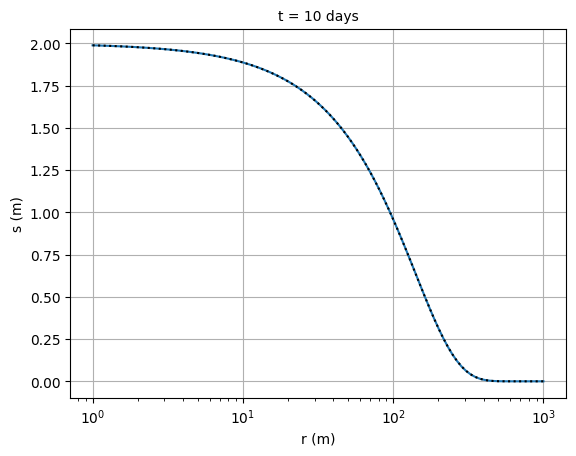

In [49]:
plt.semilogx(r, s, '-',
             r, m.h(r=r, t=t).flatten(), 'k:');
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.title(f't = {t} days', dict(fontsize=10));

### The model of Hantush-Jacob

The Hantush & Jacob (1955) solution (**Equation 149**, Section 2.5.10):

> $h = h_0 + \dfrac{Q}{4\pi T} \text{W} \bigg( \dfrac{r^2S}{4tT}, \dfrac{r}{\sqrt{c_{top}T}}\bigg)$

Rearranging into dimensionless form:

> $\dfrac{4\pi Ts}{Q} = \text{W} \bigg( \dfrac{r^2S}{4tT}, \dfrac{r}{\sqrt{c_{top}T}}\bigg)$

with $s = h - h_0$.

This solution is implemented in function `hantush_jacob`.

Creating Figure 17 (Section 2.5.10):

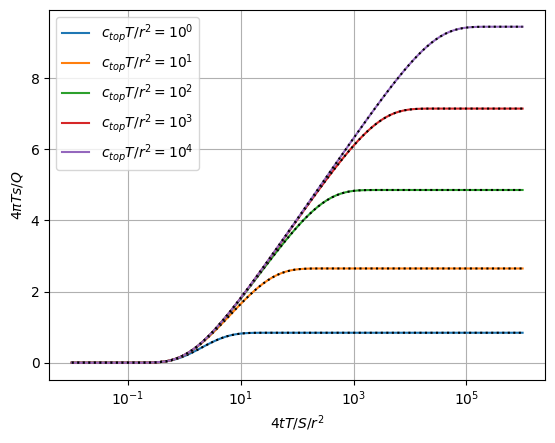

In [50]:
# solution is expressed in dimensionless form
T = S = r = 1
Q = 4 * np.pi

t = np.logspace(-2, 6, 100)  # dimensionless time 4*t*T/S/r**2

for c_top in np.logspace(0, 4, 5):  # dimensionless resistance c_top*T/r**2

    s = hantush_jacob(r=r, t=t/4, T=T, S=S, Q=Q, c_top=c_top)  # dimensionless drawdown
    plt.semilogx(t, s.T, label="$c_{top}T/r^2=10^{"+str(int(np.log10(c_top)))+"}$");

    m = Transient(T=T, S=S, Q=Q, c_top=c_top)  # initializing Transient model
    plt.semilogx(t, m.h(r=r, t=t/4).flatten(), 'k:');

plt.legend();
plt.grid();
plt.xlabel('$4tT/S/r^2$');
plt.ylabel('$4\pi Ts/Q$');

The above simulations apply the Stehfest (1970) algorithm to numerically invert the solution in the Laplace domain. Function `hantush_jacob` also implements the fast approximation of the Hantush Well function $\text{W}$ developed by Veling and Maas (2010). Let's compare both implementations:

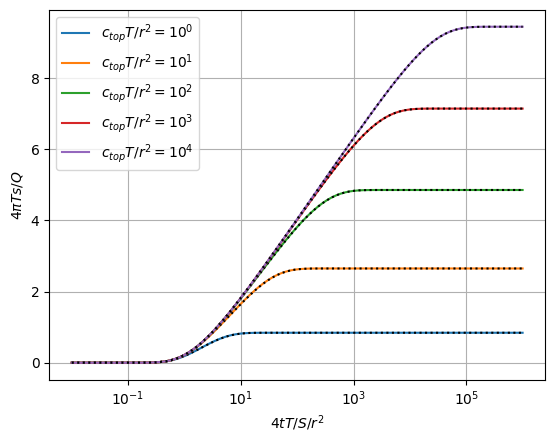

In [51]:
for c_top in np.logspace(0, 4, 5):

    # Numerical inversion of the Laplace transform:
    s = hantush_jacob(r=r, t=t/4, T=T, S=S, Q=Q, c_top=c_top)
    plt.semilogx(t, s.T, label="$c_{top}T/r^2=10^{"+str(int(np.log10(c_top)))+"}$");

    # Fast approximation of W (set input parameter ns to None):
    s = hantush_jacob(r=r, t=t/4, T=T, S=S, Q=Q, c_top=c_top, ns=None)
    plt.semilogx(t, s.T, 'k:');

plt.legend();
plt.grid();
plt.xlabel('$4tT/S/r^2$');
plt.ylabel('$4\pi Ts/Q$');

### Hemker’s solution for steady flow in a leaky multi-aquifer system

**Solution 152** (Section 2.5.11) is implemented in function `hemker_steady` (Hemker, 1984):

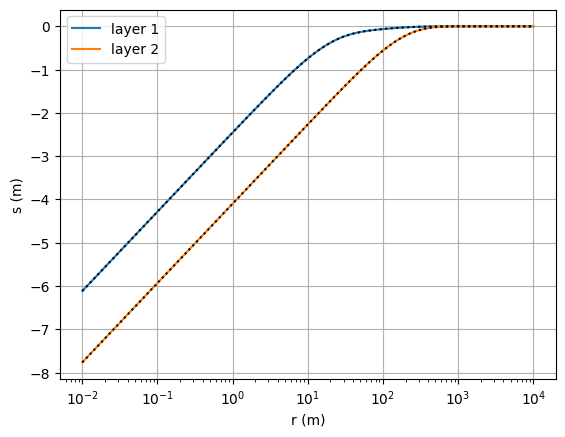

In [52]:
T = [10, 100]     # transmissivities (m²/d)
c = 200           # resistance (d) of separating layer
c_top = 25        # top resistance (d)
Q = [-50, -500]   # pumping rates (m³/d)
r = np.logspace(-2, 4, 100)  # radial distances (m)

s = hemker_steady(r=r, T=T, Q=Q, c=c, c_top=c_top)  # drawdown (m)
m = Steady(T=T, c=c, c_top=c_top, Q=Q)  # initializing Steady model

plt.semilogx(r, s.T, '-');
plt.legend(['layer 1', 'layer 2']);
plt.semilogx(r, m.h(r).T, 'k:');
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('s (m)');

Function `hemker_steady` can also be used to simulate parallel flow:

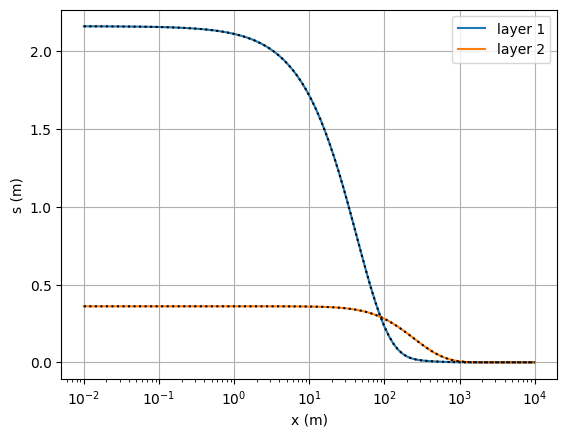

In [53]:
T = [200, 500]  # transmissivities (m²/d)
c = 100         # resistance (d) of separating layer
c_top = 10      # top resistance (d)
Q = [10, 0]     # recharge at inner model boundary (m³/d/m)
r = np.logspace(-2, 4, 100)  # horizontal distances (m)

s = hemker_steady(r=r, T=T, Q=Q, c=c, c_top=c_top, axi=False)  # head change (m)
m = Steady(T=T, c=c, c_top=c_top, Q=Q, axi=False)  # initializing Steady model

plt.semilogx(r, s.T, '-');
plt.legend(['layer 1', 'layer 2']);
plt.semilogx(r, m.h(r).T, 'k:');
plt.grid();
plt.xlabel('x (m)');  # it's common to denote horizontal distance as x
plt.ylabel('s (m)');

Creating Figure 18 (Section 2.5.11):

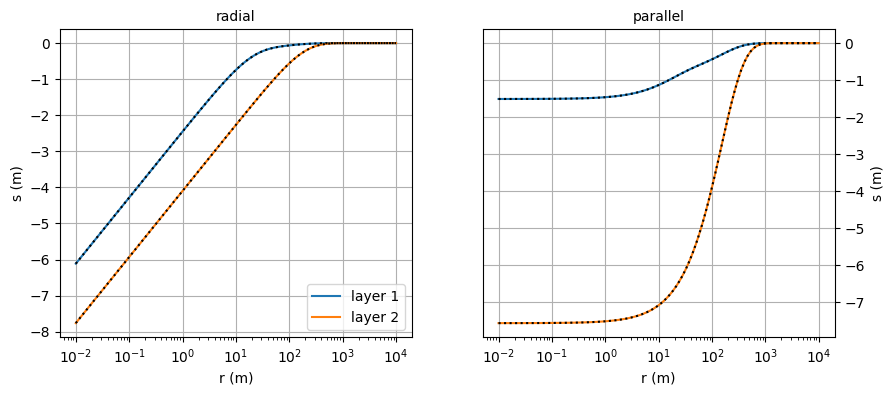

In [54]:
T = [10, 100]  # transmissivities (m²/d)
c = 200        # resistance (d) of separating layer
c_top = 25     # top resistance (d)
r = np.logspace(-2, 4, 100)  # radial distances (m)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# radial flow
Q = [-50, -500]  # pumping rates (m³/d)
s = hemker_steady(r=r, T=T, Q=Q, c=c, c_top=c_top)  # drawdown (m)
m = Steady(T=T, c=c, c_top=c_top, Q=Q)  # initializing Steady model

ax1.semilogx(r, s.T, '-');
ax1.legend(['layer 1', 'layer 2'], loc=4);
ax1.semilogx(r, m.h(r).T, 'k:');
ax1.grid();
ax1.set_xlabel('r (m)');
ax1.set_ylabel('s (m)');
ax1.set_title('radial', dict(fontsize=10));

# parallel flow
Q = [-0.5, -5]  # discharges (m²/d)
s = hemker_steady(r=r, T=T, Q=Q, c=c, c_top=c_top, axi=False)  # drawdown (m)
m = Steady(T=T, c=c, c_top=c_top, Q=Q, axi=False)  # initializing Steady model

ax2.semilogx(r, s.T, '-');
ax2.semilogx(r, m.h(r).T, 'k:');
ax2.grid();
ax2.set_xlabel('r (m)');
ax2.set_ylabel('s (m)');
ax2.yaxis.tick_right();
ax2.yaxis.set_label_position("right");
ax2.set_title('parallel', dict(fontsize=10));

### Hemker’s solution for unsteady flow in a multi-aquifer system

**Solution 154** (Section 2.5.12) is implemented in function `hemker_unsteady` (Hemker, 1985):

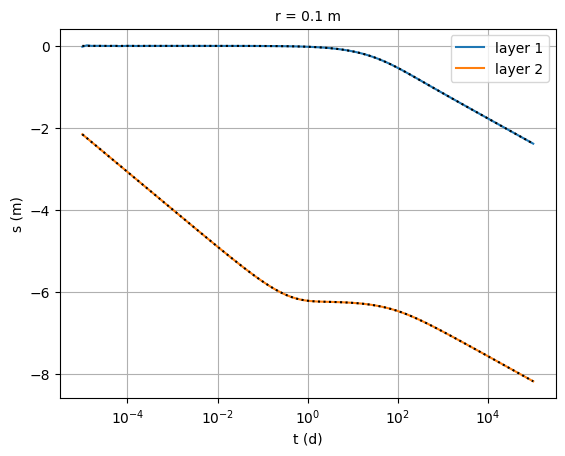

In [55]:
T = [50, 100]     # aquifer transmissivities (m²/d)
S = [0.2, 0.001]  # aquifer storativities (-)
c = 500           # resistance (d) of separating aquitard
Q = -500          # pumping rate (m³/d) of well in lower aquifer
r = 0.1           # radial distance (m)
t = np.logspace(-5, 5, 100)  # times (d)

s = hemker_unsteady(r=r, t=t, T=T, S=S, Q=Q, c=c)  # drawdown (m)
m = Transient(T=T, S=S, c=c, Q=[0, Q])  # initializing Transient model

plt.semilogx(t, s.squeeze().T, '-');
plt.legend(['layer 1', 'layer 2']);
plt.semilogx(t, m.h(r, t).squeeze().T, 'k:');
plt.grid();
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.title(f'r = {r} m', fontdict=dict(fontsize=10));

The same solution can be simulated using function `hunt_scott` (Hunt & Scott, 2007):

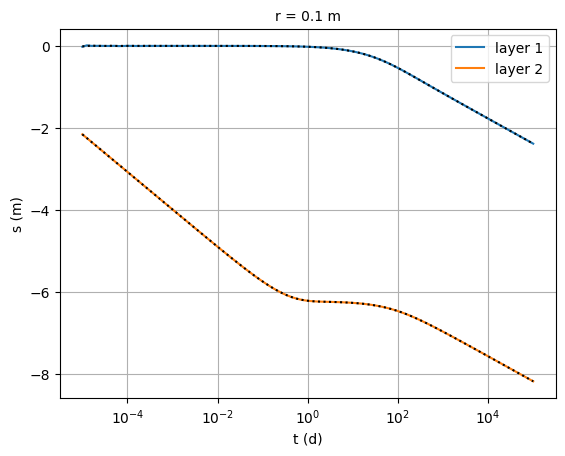

In [56]:
s1 = hemker_unsteady(r=r, t=t, T=T, S=S, Q=Q, c=c)  # Hemker's solution
s2 = hunt_scott(r=r, t=t, T=T, S=S, Q=Q, c=c)  # Hunt & Scott's solution

plt.semilogx(t, s1.squeeze().T, '-');
plt.legend(['layer 1', 'layer 2']);
plt.semilogx(t, s2.squeeze().T, 'k:');
plt.grid();
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.title(f'r = {r} m', fontdict=dict(fontsize=10));

Functions `hemker_unsteady` and `hunt_scott` are different solutions for the same confined two-layer model. Only pumping in the lower layer is allowed, which explains why only one `Q` value is given. Class `Transient` requires two values for `Q`. Here, the first element in `Q` is zero as there is no pumping in the upper layer.

Function `hemker_unsteady` can also be used to simulate parallel flow:

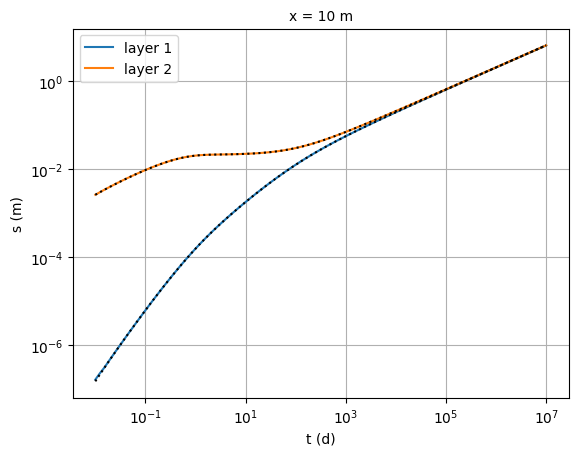

In [57]:
T = [50, 100]     # aquifer transmissivities (m²/d)
S = [0.2, 0.001]  # aquifer storativities (-)
c = 500           # resistance (d) of separating aquitard
Q = 0.01          # recharge (m³/d/m) in lower aquifer at inner boundary
r = 10            # horizontal distance (m)
t = np.logspace(-2, 7, 100)  # times (d)

s = hemker_unsteady(r=r, t=t, T=T, S=S, Q=Q, c=c, axi=False)  # drawdown (m)
m = Transient(T=T, S=S, c=c, Q=[0, Q], axi=False)  # initializing Transient model

plt.loglog(t, s.squeeze().T, '-');
plt.legend(['layer 1', 'layer 2']);
plt.loglog(t, m.h(r, t).squeeze().T, 'k:');
plt.grid();
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.title(f'x = {r} m', fontdict=dict(fontsize=10));

Creating Figure 19 (Section 2.5.12):

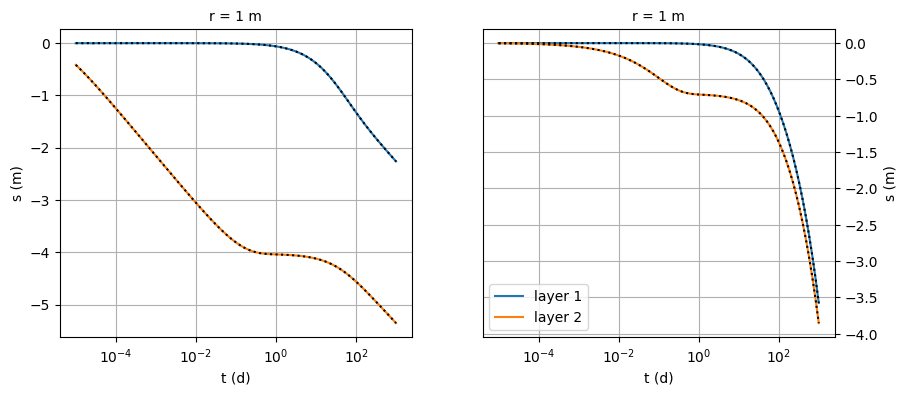

In [58]:
T = [10, 100]     # aquifer transmissivities (m²/d)
S = [0.2, 0.001]  # aquifer storativities (-)
c = 200           # resistance (d) of separating layer
r = 1             # distance (m)
t = np.logspace(-5, 3, 100)  # times (d)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# radial flow
Q = -500  # pumping rate (m³/d) in lower aquifer
s = hemker_unsteady(r=r, t=t, T=T, S=S, Q=Q, c=c)  # drawdown (m)
m = Transient(T=T, S=S, c=c, Q=[0, Q])  # initializing Transient model

ax1.semilogx(t, s.squeeze().T, '-');
ax1.semilogx(t, m.h(r, t).squeeze().T, 'k:');
ax1.grid();
ax1.set_xlabel('t (d)');
ax1.set_ylabel('s (m)');
ax1.set_title(f'r = {r} m', fontdict=dict(fontsize=10));

# parallel flow
Q = -0.5  # discharge (m²/d)
s = hemker_unsteady(r=r, t=t, T=T, S=S, Q=Q, c=c, axi=False)  # drawdown (m)
m = Transient(T=T, S=S, c=c, Q=[0, Q], axi=False)  # initializing Transient model

ax2.semilogx(t, s.squeeze().T, '-');
ax2.legend(['layer 1', 'layer 2']);
ax2.semilogx(t, m.h(r, t).squeeze().T, 'k:');
ax2.grid();
ax2.set_xlabel('t (d)');
ax2.set_ylabel('s (m)');
ax2.yaxis.tick_right();
ax2.yaxis.set_label_position("right");
ax2.set_title(f'r = {r} m', fontdict=dict(fontsize=10));

### Steady flow in a confined multi-aquifer system

**Solution 156** (Section 2.5.13) is implemented in function `bakker_strack` (Bakker & Strack, 2003):

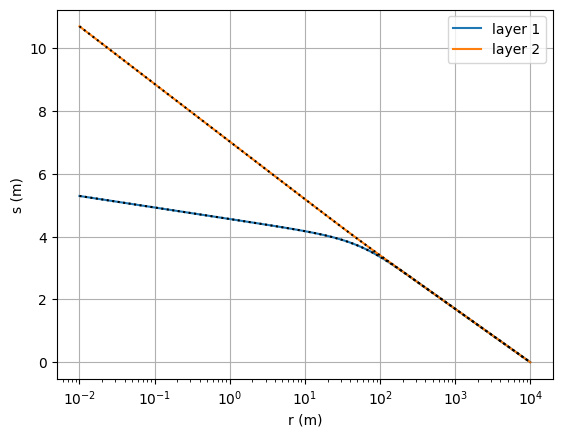

In [59]:
T = [10, 100]   # transmissivities (m²/d)
c = 200         # resistance (d) of separating layer
Q = [10, 500]   # injection rates (m³/d)
r_out = 10_000  # distance (m) of outer model boundary
r = np.logspace(-2, np.log10(r_out), 100)  # radial distances (m)

s = bakker_strack(r=r, T=T, Q=Q, c=c, r_out=r_out)  # head change (m)
m = Steady(T=T, c=c, Q=Q, r_out=r_out)  # initializing Steady model

plt.semilogx(r, s.T, '-');
plt.legend(['layer 1', 'layer 2']);
plt.semilogx(r, m.h(r).T, 'k:');
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('s (m)');

Function `bakker_strack` also implements **solution 157** (Section 2.5.13) to take into account recharge (Bakker & Strack, 2003):

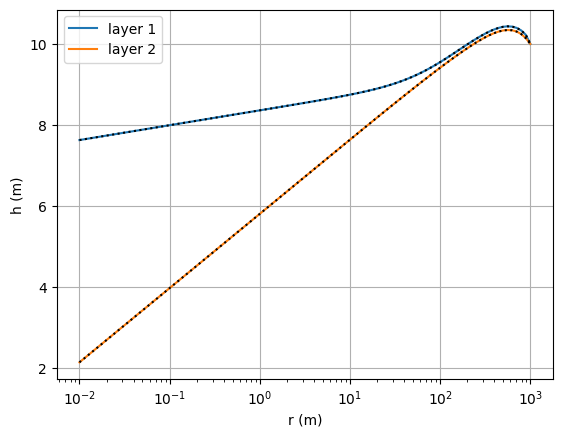

In [60]:
T = [10, 100]    # transmissivities (m²/d)
c = 200          # resistance (d) of separating layer
Q = [-10, -500]  # pumping rates (m³/d)
N = 5e-4         # infiltration flux (m/d)
r_out = 1000     # distance (m) of outer model boundary
h_out = 10       # constant head (m) at the outer model boundary
r = np.logspace(-2, np.log10(r_out), 100)  # radial distances (m)

h = bakker_strack(r=r, T=T, Q=Q, c=c, r_out=r_out, h_out=h_out, N=N)  # head (m)
m = Steady(T=T, c=c, Q=Q, r_out=r_out, h_out=[h_out, h_out], N=[N, 0])  # initializing Steady model

plt.semilogx(r, h.T, '-');
plt.legend(['layer 1', 'layer 2']);
plt.semilogx(r, m.h(r).T, 'k:');
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('h (m)');

Note that function `bakker_strack` only considers recharge in the top layer, which explains why only one `N` value is given. Class `Transient` requires two values for `N`. Here, the second entry of `N` is zero as there is no recharge in the lower layer.

Creating Figure 20 (Section 2.5.13):

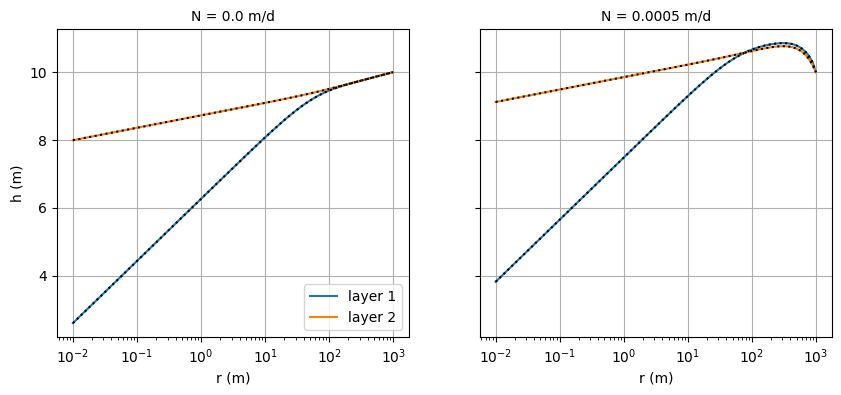

In [61]:
T = [10, 100]    # transmissivities (m²/d)
Q = [-50, -100]  # pumping rates (m³/d)
c = 200          # resistance (d) of separating layer
N = 5e-4         # infiltration flux (m/d)
r_out = 1000     # distance (m) of outer model boundary
h_out = 10       # constant head (m) at the outer model boundary
r = np.logspace(-2, np.log10(r_out), 100)  # radial distances (m)

_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# no recharge
h = bakker_strack(r=r, T=T, Q=Q, c=c, r_out=r_out, h_out=h_out)  # head (m)
m = Steady(T=T, c=c, Q=Q, r_out=r_out, h_out=[h_out, h_out])  # initializing Steady model

ax1.semilogx(r, h.T, '-');
ax1.legend(['layer 1', 'layer 2'], loc=4);
ax1.semilogx(r, m.h(r).T, 'k:');
ax1.grid();
ax1.set_xlabel('r (m)');
ax1.set_ylabel('h (m)');
ax1.set_title('N = 0.0 m/d', dict(fontsize=10));

# recharge
h = bakker_strack(r=r, T=T, Q=Q, c=c, r_out=r_out, h_out=h_out, N=N)  # head (m)
m = Steady(T=T, c=c, Q=Q, r_out=r_out, h_out=[h_out, h_out], N=[N, 0])  # initializing Steady model

ax2.semilogx(r, h.T, '-');
ax2.semilogx(r, m.h(r).T, 'k:');
ax2.grid();
ax2.set_xlabel('r (m)');
ax2.set_title(f'N = {N} m/d', dict(fontsize=10));

## References

- Bakker, M., & Strack, O. D. L. (2003). Analytic elements for multiaquifer flow. Journal of Hydrology, 271(1–4). https://doi.org/10.1016/S0022-1694(02)00319-0

- Bruggeman, G. A. (1999). Analytical solutions of geohydrological problems. Developments in Water Science 46. Amsterdam: Elsevier.

- Darcy, H. (1856). Les fontaines publiques de la ville de Dijon (In French). Paris: Dalmont.

- de Glee, G. J. (1930). Over grondwaterstroomingen bij wateronttrekking door middel van putten (in Dutch) (PhD thesis). Technische Hoogeschool Delft, Drukkerij J. Waltman. Jr., Delft. http://resolver.tudelft.nl/uuid:c3e13209-4626-41b9-9038-c223d61e35c4

- Dupuit, J. (1863). Etude Théoriques et Pratiques Sur le Mouvement Des Eaux Dans Les Canaux Découverts et à Travers Les Terrains Perméables (in French). Paris: Dunot.

- Edelman, J. H. (1947). Over de berekening van grondwaterstroomingen (in Dutch). TU Delft, Delft. http://resolver.tudelft.nl/uuid:eafb0519-5a88-431a-8a93-3f6e33492883

- Haitjema, H. (1995). Analytic Element Modeling of Groundwater Flow. San Diego: Academic Press. https://doi.org/10.1016/B978-0-12-316550-3.X5000-4

- Hantush, M. S., & Jacob, C. E. (1955). Non-steady radial flow in an infinite leaky aquifer. Transactions, American Geophysical Union, 36(1), 95–100. https://doi.org/10.1029/TR036i001p00095

- Hemker, C. J. (1984). Steady groundwater flow in leaky multiple-aquifer systems. Journal of Hydrology, 72(3–4), 355–374. https://doi.org/10.1016/0022-1694(84)90089-1

- Hemker, C. J. (1985). Transient well flow in leaky multiple-aquifer systems. Journal of Hydrology, 81(1–2), 111–126. https://doi.org/10.1016/0022-1694(85)90170-2

- Hunt, B., & Scott, D. (2007). Flow to a Well in a Two-Aquifer System. Journal of Hydrologic Engineering, 12(2), 146–155. https://doi.org/10.1061/(ASCE)1084-0699(2007)12:2(146)

- Jacob, C. E. (1946). Radial flow in a leaky artesian aquifer. Transactions, American Geophysical Union, 27(2). https://doi.org/10.1029/TR027i002p00198

- Kooper, J. (1914). Beweging van het water in den bodem bij onttrekking door bronnen (in Dutch). Ingenieur, 29, 697–716.

- Kruseman, G. P., & de Ridder, N. A. (1990). Analysis and Evaluation of Pumping Test Data (2nd ed.). Wageningen: ILRI Publication 47.

- Louwyck, A. (2023). Axisymmetric Flow in Multilayer Aquifer Systems: Solutions and Theoretical Considerations. PhD thesis, Laboratory for Applied Geology and Hydrogeology, Department of Geology, Ghent University, Belgium.

- Louwyck, A., Vandenbohede, A., Libbrecht, D., Van Camp, M., & Walraevens, K. (2022). The Radius of Influence Myth. Water, 14(2), 149. https://doi.org/10.3390/w14020149

- Stehfest, H. (1970). Algorithm 368: Numerical inversion of Laplace transforms [D5]. Communications of the ACM, 13(1), 47–49. https://doi.org/10.1145/361953.361969

- Strack, O. D. L. (1989). Groundwater Mechanics. Old Tappan, N. J.: Prentice-Hall.

- Theis, C. V. (1935). The relation between the lowering of the Piezometric surface and the rate and duration of discharge of a well using ground-water storage. Transactions, American Geophysical Union, 16(2), 519–524. https://doi.org/10.1029/TR016i002p00519

- Theis, C. V. (1941). The effect of a well on the flow of a nearby stream. Transactions, American Geophysical Union, 22(3), 734. https://doi.org/10.1029/TR022i003p00734

- Thiem, A. (1870). Die Ergiebigkeit artesischer Bohrlöcher, Schachtbrunnen und Filtergalerien (in German). Journal Für Gasbeleuchtung Und Wasserversorgung, 13, 450–467.

- Thiem, G. (1906). Hydrologische Methoden (in German). Leipzig: Gebhardt.

- Veling, E. J. M., & Maas, C. (2010). Hantush Well Function revisited. Journal of Hydrology, 393(3–4). https://doi.org/10.1016/j.jhydrol.2010.08.033


---